# Download Dataset

In [ ]:
!wget https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip

--2024-11-30 15:04:52--  https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘predict+students+dropout+and+academic+success.zip’

predict+students+dr     [  <=>               ] 520.84K  2.06MB/s    in 0.2s    

2024-11-30 15:04:53 (2.06 MB/s) - ‘predict+students+dropout+and+academic+success.zip’ saved [533344]



In [ ]:
!unzip predict+students+dropout+and+academic+success.zip

Archive:  predict+students+dropout+and+academic+success.zip
 extracting: data.csv                


# Load Dataset

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
data = pd.read_csv('/content/data.csv', sep = ';')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [ ]:
print("Missing values in Dataset\n", data.isna().sum(), sep='')

Missing values in Dataset
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                    

In [ ]:
data = data.drop(data[data['Target'] == 'Enrolled'].index).reset_index(drop=True)

In [ ]:
data.shape

(3630, 37)

# Overview Dataset

In [ ]:
# Xây dựng hàm chuyển đổi Target (Graduate:1 , Dropout:0)
def encode_target(target):
    if target == 'Dropout':
        return 0
    return 1
data['Target'] = data['Target'].apply(encode_target)

# Thống kê mô tả

In [ ]:
data.describe()

Marital status  Application mode  Application order       Course  \
count     3630.000000       3630.000000        3630.000000  3630.000000   
mean         1.184298         18.421763           1.750138  8853.980992   
std          0.613009         17.358595           1.333831  2068.760082   
min          1.000000          1.000000           0.000000    33.000000   
25%          1.000000          1.000000           1.000000  9085.000000   
50%          1.000000         17.000000           1.000000  9254.000000   
75%          1.000000         39.000000           2.000000  9556.000000   
max          6.000000         57.000000           6.000000  9991.000000   

       Daytime/evening attendance\t  Previous qualification  \
count                   3630.000000             3630.000000   
mean                       0.887603                4.532231   
std                        0.315897               10.024134   
min                        0.000000                1.000000   
25%                        1.000000                1.000000   
50%                        1.000000                1.000000   
75%                        1.000000                1.000000   
max                        1.000000               43.000000   

       Previous qualification (grade)  Nacionality  Mother's qualification  \
count                     3630.000000  3630.000000             3630.000000   
mean                       132.920606     1.828099               19.986226   
std                         13.238373     6.667614               15.585278   
min                         95.000000     1.000000                1.000000   
25%                        125.000000     1.000000                2.000000   
50%                        133.100000     1.000000               19.000000   
75%                        140.000000     1.000000               37.000000   
max                        190.000000   109.000000               44.000000   

       Father's qualification  ...  Curricular units 2nd sem (credited)  \
count             3630.000000  ...                          3630.000000   
mean                22.571625  ...                             0.581818   
std                 15.275453  ...                             2.022688   
min                  1.000000  ...                             0.000000   
25%                  3.000000  ...                             0.000000   
50%                 19.000000  ...                             0.000000   
75%                 37.000000  ...                             0.000000   
max                 44.000000  ...                            19.000000   

       Curricular units 2nd sem (enrolled)  \
count                          3630.000000   
mean                              6.296419   
std                               2.263020   
min                               0.000000   
25%                               5.000000   
50%                               6.000000   
75%                               7.000000   
max                              23.000000   

       Curricular units 2nd sem (evaluations)  \
count                             3630.000000   
mean                                 7.763085   
std                                  3.964163   
min                                  0.000000   
25%                                  6.000000   
50%                                  8.000000   
75%                                 10.000000   
max                                 33.000000   

       Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
count                          3630.000000                       3630.000000   
mean                              4.518457                         10.036155   
std                               3.162376                          5.481742   
min                               0.000000                          0.000000   
25%                               2.000000                         10.517857   
50%                               5.000000     

In [ ]:
def split_df_CategoricalNumerical(df: pd.DataFrame) -> list[pd.DataFrame, pd.DataFrame]:
    numerical_cols = list(df.select_dtypes(include='float').columns)
    numerical_cols += ['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)',
                       'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (without evaluations)',
                       'Age at enrollment']

    categorical_cols = [x for x in df.columns if x not in numerical_cols]

    df_numerical = df[numerical_cols + ['Target']] # Append Target to Analysis
    df_categorical = df[categorical_cols]
    return df_numerical, df_categorical

df_nums, df_cates = split_df_CategoricalNumerical(data)

In [ ]:
df_nums.shape, df_cates.shape

((3630, 19), (3630, 19))

In [ ]:
def split_df_CountUnique(df: pd.DataFrame) -> list[pd.DataFrame, pd.DataFrame]:
    cols_two = []
    cols_remaining = []
    for col in df.columns:
        if len(df[col].unique()) == 2:
            cols_two.append(col)
        else:
            cols_remaining.append(col)
    df_category_two = df[cols_two]
    df_remaining = df[cols_remaining]
    return df_category_two, df_remaining

df_category_two, df_category_remaining = split_df_CountUnique(df_cates)

In [ ]:
def create_dict_matching(input_string: str):
    input_string = re.sub("–", "-", input_string)
    pattern = r"(\d+) - (.*?)(?= \d+ -|$)"
    matches = re.findall(pattern, input_string)
    return {int(_match[0]): _match[1].strip() for _match in matches}

In [ ]:
def calculate_frequency(series):
    frequency = series.value_counts(normalize=True).reset_index()
    frequency.columns = ['Value', 'Frequency']
    return frequency

## Biến phân loại với 2 giá trị

In [ ]:
def setup_labels(col_name: str):
    if col_name == 'Marital status':
        description = "1 – single 2 – married 3 – widower 4 – divorced 5 – facto union 6 – legally separated"
        return create_dict_matching(description)
    elif col_name == 'Application mode':
        description = "1 - 1st phase - general contingent 2 - Ordinance No. 612/93 5 - 1st phase - special contingent (Azores Island) 7 - Holders of other higher courses 10 - Ordinance No. 854-B/99 15 - International student (bachelor) 16 - 1st phase - special contingent (Madeira Island) 17 - 2nd phase - general contingent 18 - 3rd phase - general contingent 26 - Ordinance No. 533-A/99, item b2) (Different Plan) 27 - Ordinance No. 533-A/99, item b3 (Other Institution) 39 - Over 23 years old 42 - Transfer 43 - Change of course 44 - Technological specialization diploma holders 51 - Change of institution/course 53 - Short cycle diploma holders 57 - Change of institution/course (International)"
        return create_dict_matching(description)
    elif col_name == 'Course':
        description = "33 - Biofuel Production Technologies 171 - Animation and Multimedia Design 8014 - Social Service (evening attendance) 9003 - Agronomy 9070 - Communication Design 9085 - Veterinary Nursing 9119 - Informatics Engineering 9130 - Equinculture 9147 - Management 9238 - Social Service 9254 - Tourism 9500 - Nursing 9556 - Oral Hygiene 9670 - Advertising and Marketing Management 9773 - Journalism and Communication 9853 - Basic Education 9991 - Management (evening attendance)"
        return create_dict_matching(description)
    elif col_name == 'Previous qualification':
        description = "1 - Secondary education 2 - Higher education - bachelor's degree 3 - Higher education - degree 4 - Higher education - master's 5 - Higher education - doctorate 6 - Frequency of higher education 9 - 12th year of schooling - not completed 10 - 11th year of schooling - not completed 12 - Other - 11th year of schooling 14 - 10th year of schooling 15 - 10th year of schooling - not completed 19 - Basic education 3rd cycle (9th/10th/11th year) or equiv. 38 - Basic education 2nd cycle (6th/7th/8th year) or equiv. 39 - Technological specialization course 40 - Higher education - degree (1st cycle) 42 - Professional higher technical course 43 - Higher education - master (2nd cycle)"
        return create_dict_matching(description)
    elif col_name == 'Nacionality':
        description = "1 - Portuguese; 2 - German; 6 - Spanish; 11 - Italian; 13 - Dutch; 14 - English; 17 - Lithuanian; 21 - Angolan; 22 - Cape Verdean; 24 - Guinean; 25 - Mozambican; 26 - Santomean; 32 - Turkish; 41 - Brazilian; 62 - Romanian; 100 - Moldova (Republic of); 101 - Mexican; 103 - Ukrainian; 105 - Russian; 108 - Cuban; 109 - Colombian"
        return create_dict_matching(description)
    elif col_name == "Mother's qualification":
        description = "1 - Secondary Education - 12th Year of Schooling or Eq. 2 - Higher Education - Bachelor's Degree 3 - Higher Education - Degree 4 - Higher Education - Master's 5 - Higher Education - Doctorate 6 - Frequency of Higher Education 9 - 12th Year of Schooling - Not Completed 10 - 11th Year of Schooling - Not Completed 11 - 7th Year (Old) 12 - Other - 11th Year of Schooling 14 - 10th Year of Schooling 18 - General commerce course 19 - Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv. 22 - Technical-professional course 26 - 7th year of schooling 27 - 2nd cycle of the general high school course 29 - 9th Year of Schooling - Not Completed 30 - 8th year of schooling 34 - Unknown 35 - Can't read or write 36 - Can read without having a 4th year of schooling 37 - Basic education 1st cycle (4th/5th year) or equiv. 38 - Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv. 39 - Technological specialization course 40 - Higher education - degree (1st cycle) 41 - Specialized higher studies course 42 - Professional higher technical course 43 - Higher Education - Master (2nd cycle) 44 - Higher Education - Doctorate (3rd cycle)"
        return create_dict_matching(description)
    elif col_name == "Father's qualification":
        description = "1 - Secondary Education - 12th Year of Schooling or Eq. 2 - Higher Education - Bachelor's Degree 3 - Higher Education - Degree 4 - Higher Education - Master's 5 - Higher Education - Doctorate 6 - Frequency of Higher Education 9 - 12th Year of Schooling - Not Completed 10 - 11th Year of Schooling - Not Completed 11 - 7th Year (Old) 12 - Other - 11th Year of Schooling 13 - 2nd year complementary high school course 14 - 10th Year of Schooling 18 - General commerce course 19 - Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv. 20 - Complementary High School Course 22 - Technical-professional course 25 - Complementary High School Course - not concluded 26 - 7th year of schooling 27 - 2nd cycle of the general high school course 29 - 9th Year of Schooling - Not Completed 30 - 8th year of schooling 31 - General Course of Administration and Commerce 33 - Supplementary Accounting and Administration 34 - Unknown 35 - Can't read or write 36 - Can read without having a 4th year of schooling 37 - Basic education 1st cycle (4th/5th year) or equiv. 38 - Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv. 39 - Technological specialization course 40 - Higher education - degree (1st cycle) 41 - Specialized higher studies course 42 - Professional higher technical course 43 - Higher Education - Master (2nd cycle) 44 - Higher Education - Doctorate (3rd cycle)"
        return create_dict_matching(description)
    elif col_name == "Mother's occupation":
        description = "0 - Student 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 2 - Specialists in Intellectual and Scientific Activities 3 - Intermediate Level Technicians and Professions 4 - Administrative staff 5 - Personal Services, Security and Safety Workers and Sellers 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 7 - Skilled Workers in Industry, Construction and Craftsmen 8 - Installation and Machine Operators and Assembly Workers 9 - Unskilled Workers 10 - Armed Forces Professions 90 - Other Situation 99 - (blank) 122 - Health professionals 123 - teachers 125 - Specialists in information and communication technologies (ICT) 131 - Intermediate level science and engineering technicians and professions 132 - Technicians and professionals, of intermediate level of health 134 - Intermediate level technicians from legal, social, sports, cultural and similar services 141 - Office workers, secretaries in general and data processing operators 143 - Data, accounting, statistical, financial services and registry-related operators 144 - Other administrative support staff 151 - personal service workers 152 - sellers 153 - Personal care workers and the like 171 - Skilled construction workers and the like, except electricians 173 - Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like 175 - Workers in food processing, woodworking, clothing and other industries and crafts 191 - cleaning workers 192 - Unskilled workers in agriculture, animal production, fisheries and forestry 193 - Unskilled workers in extractive industry, construction, manufacturing and transport 194 - Meal preparation assistants"
        return create_dict_matching(description)
    elif col_name == "Father's occupation":
        description = "0 - Student 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 2 - Specialists in Intellectual and Scientific Activities 3 - Intermediate Level Technicians and Professions 4 - Administrative staff 5 - Personal Services, Security and Safety Workers and Sellers 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 7 - Skilled Workers in Industry, Construction and Craftsmen 8 - Installation and Machine Operators and Assembly Workers 9 - Unskilled Workers 10 - Armed Forces Professions 90 - Other Situation 99 - (blank) 101 - Armed Forces Officers 102 - Armed Forces Sergeants 103 - Other Armed Forces personnel 112 - Directors of administrative and commercial services 114 - Hotel, catering, trade and other services directors 121 - Specialists in the physical sciences, mathematics, engineering and related techniques 122 - Health professionals 123 - teachers 124 - Specialists in finance, accounting, administrative organization, public and commercial relations 131 - Intermediate level science and engineering technicians and professions 132 - Technicians and professionals, of intermediate level of health 134 - Intermediate level technicians from legal, social, sports, cultural and similar services 135 - Information and communication technology technicians 141 - Office workers, secretaries in general and data processing operators 143 - Data, accounting, statistical, financial services and registry-related operators 144 - Other administrative support staff 151 - personal service workers 152 - sellers 153 - Personal care workers and the like 154 - Protection and security services personnel 161 - Market-oriented farmers and skilled agricultural and animal production workers 163 - Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence 171 - Skilled construction workers and the like, except electricians 172 - Skilled workers in metallurgy, metalworking and similar 174 - Skilled workers in electricity and electronics 175 - Workers in food processing, woodworking, clothing and other industries and crafts 181 - Fixed plant and machine operators 182 - assembly workers 183 - Vehicle drivers and mobile equipment operators 192 - Unskilled workers in agriculture, animal production, fisheries and forestry 193 - Unskilled workers in extractive industry, construction, manufacturing and transport 194 - Meal preparation assistants 195 - Street vendors (except food) and street service providers"
        return create_dict_matching(description)
    elif col_name == 'Daytime/evening attendance\t':
        return {0: 'Daytime', 1: 'Evening'}
    elif col_name == 'Gender':
        return {0: 'Male', 1: 'Female'}
    elif col_name == 'Target':
        return {0: 'Non-Graduate', 1: 'Graduate'}
    return {0: 'No', 1: 'Yes'}

<ipython-input-28-b437cb63167c>:21: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


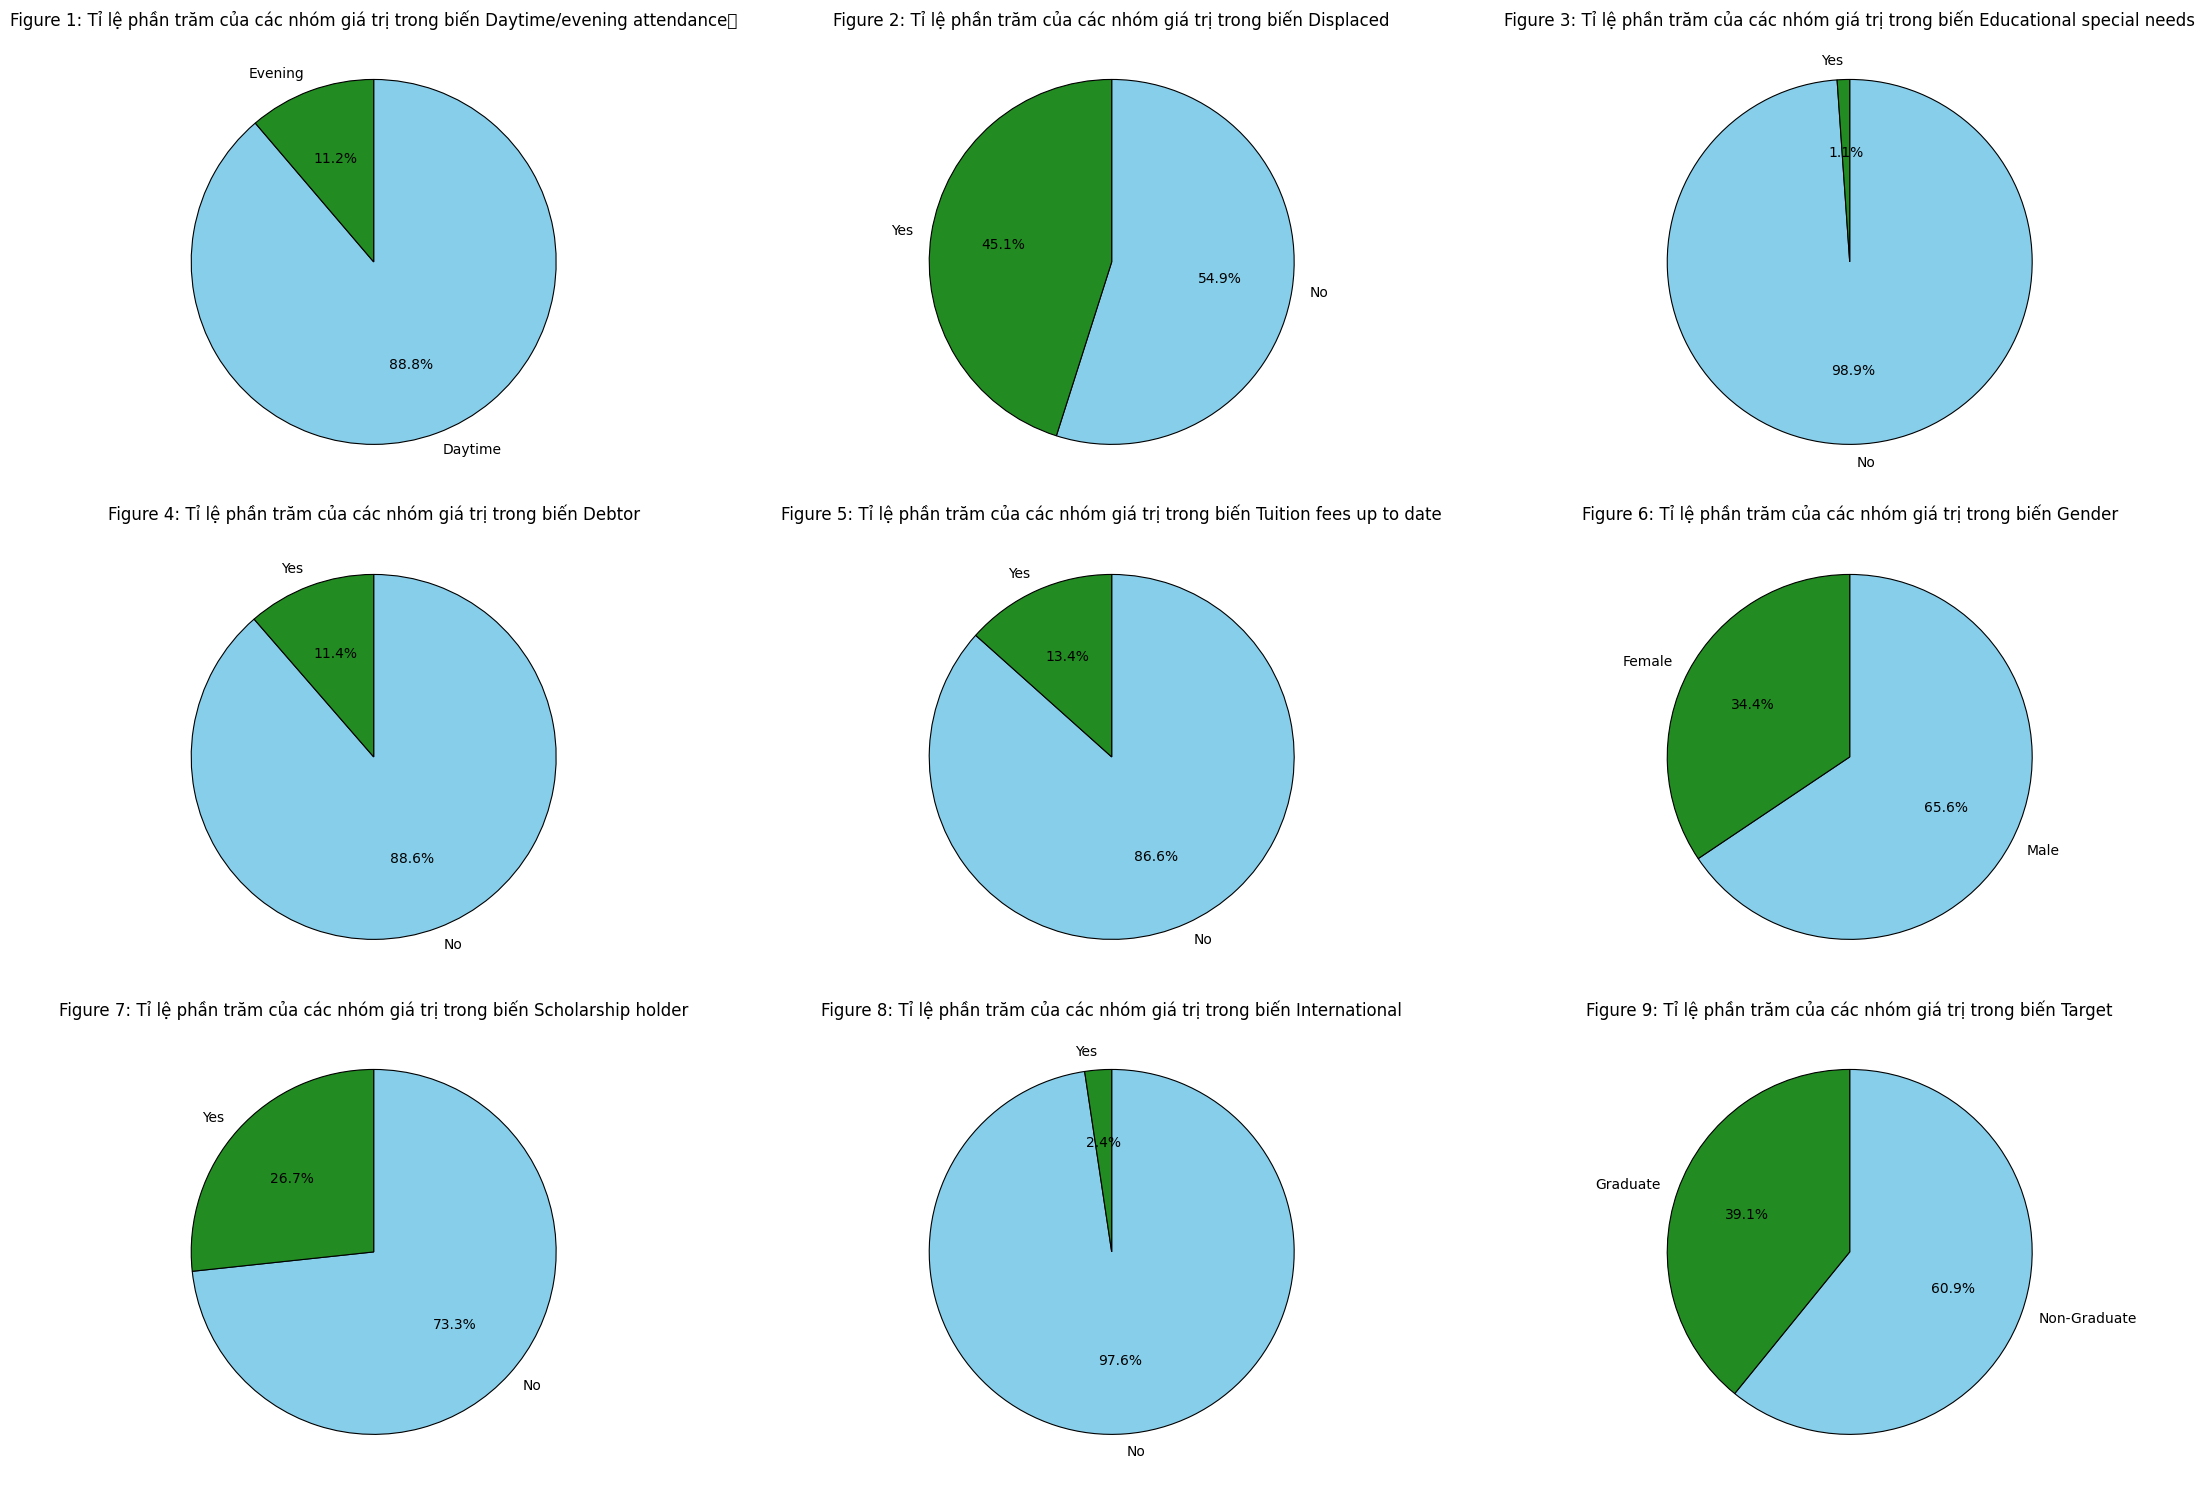

In [ ]:
def visulize_pies(df: pd.DataFrame):
    columns_two = list(df.columns)
    wedgeprops = {'edgecolor': 'black', 'linewidth': 0.8}

    n_rows = 3
    n_cols = 3

    fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_rows * 8, n_cols * 5))

    for row in range(0, n_rows):
        for col in range(0, n_cols):
            i = row*n_cols + col
            if i < len(columns_two):
                ax_i = ax[row, col]
                labels = setup_labels(columns_two[i]).values()
                sizes = calculate_frequency(df[columns_two[i]])['Frequency']
                ax_i.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'forestgreen'], wedgeprops=wedgeprops, counterclock=False)
                ax_i.set_title(f"Figure {i+1}: Tỉ lệ phần trăm của các nhóm giá trị trong biến {columns_two[i]}")
            else:
                ax[row, col].set_visible(False)
    plt.tight_layout()
    plt.show()

visulize_pies(df_category_two)

In [ ]:
def prepare_to_bars(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if col == 'Target':
            continue
        else:
            settings = setup_labels(col)
            df[col] = df[col].replace(settings)
    return df

<ipython-input-30-e821c2a61512>:21: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


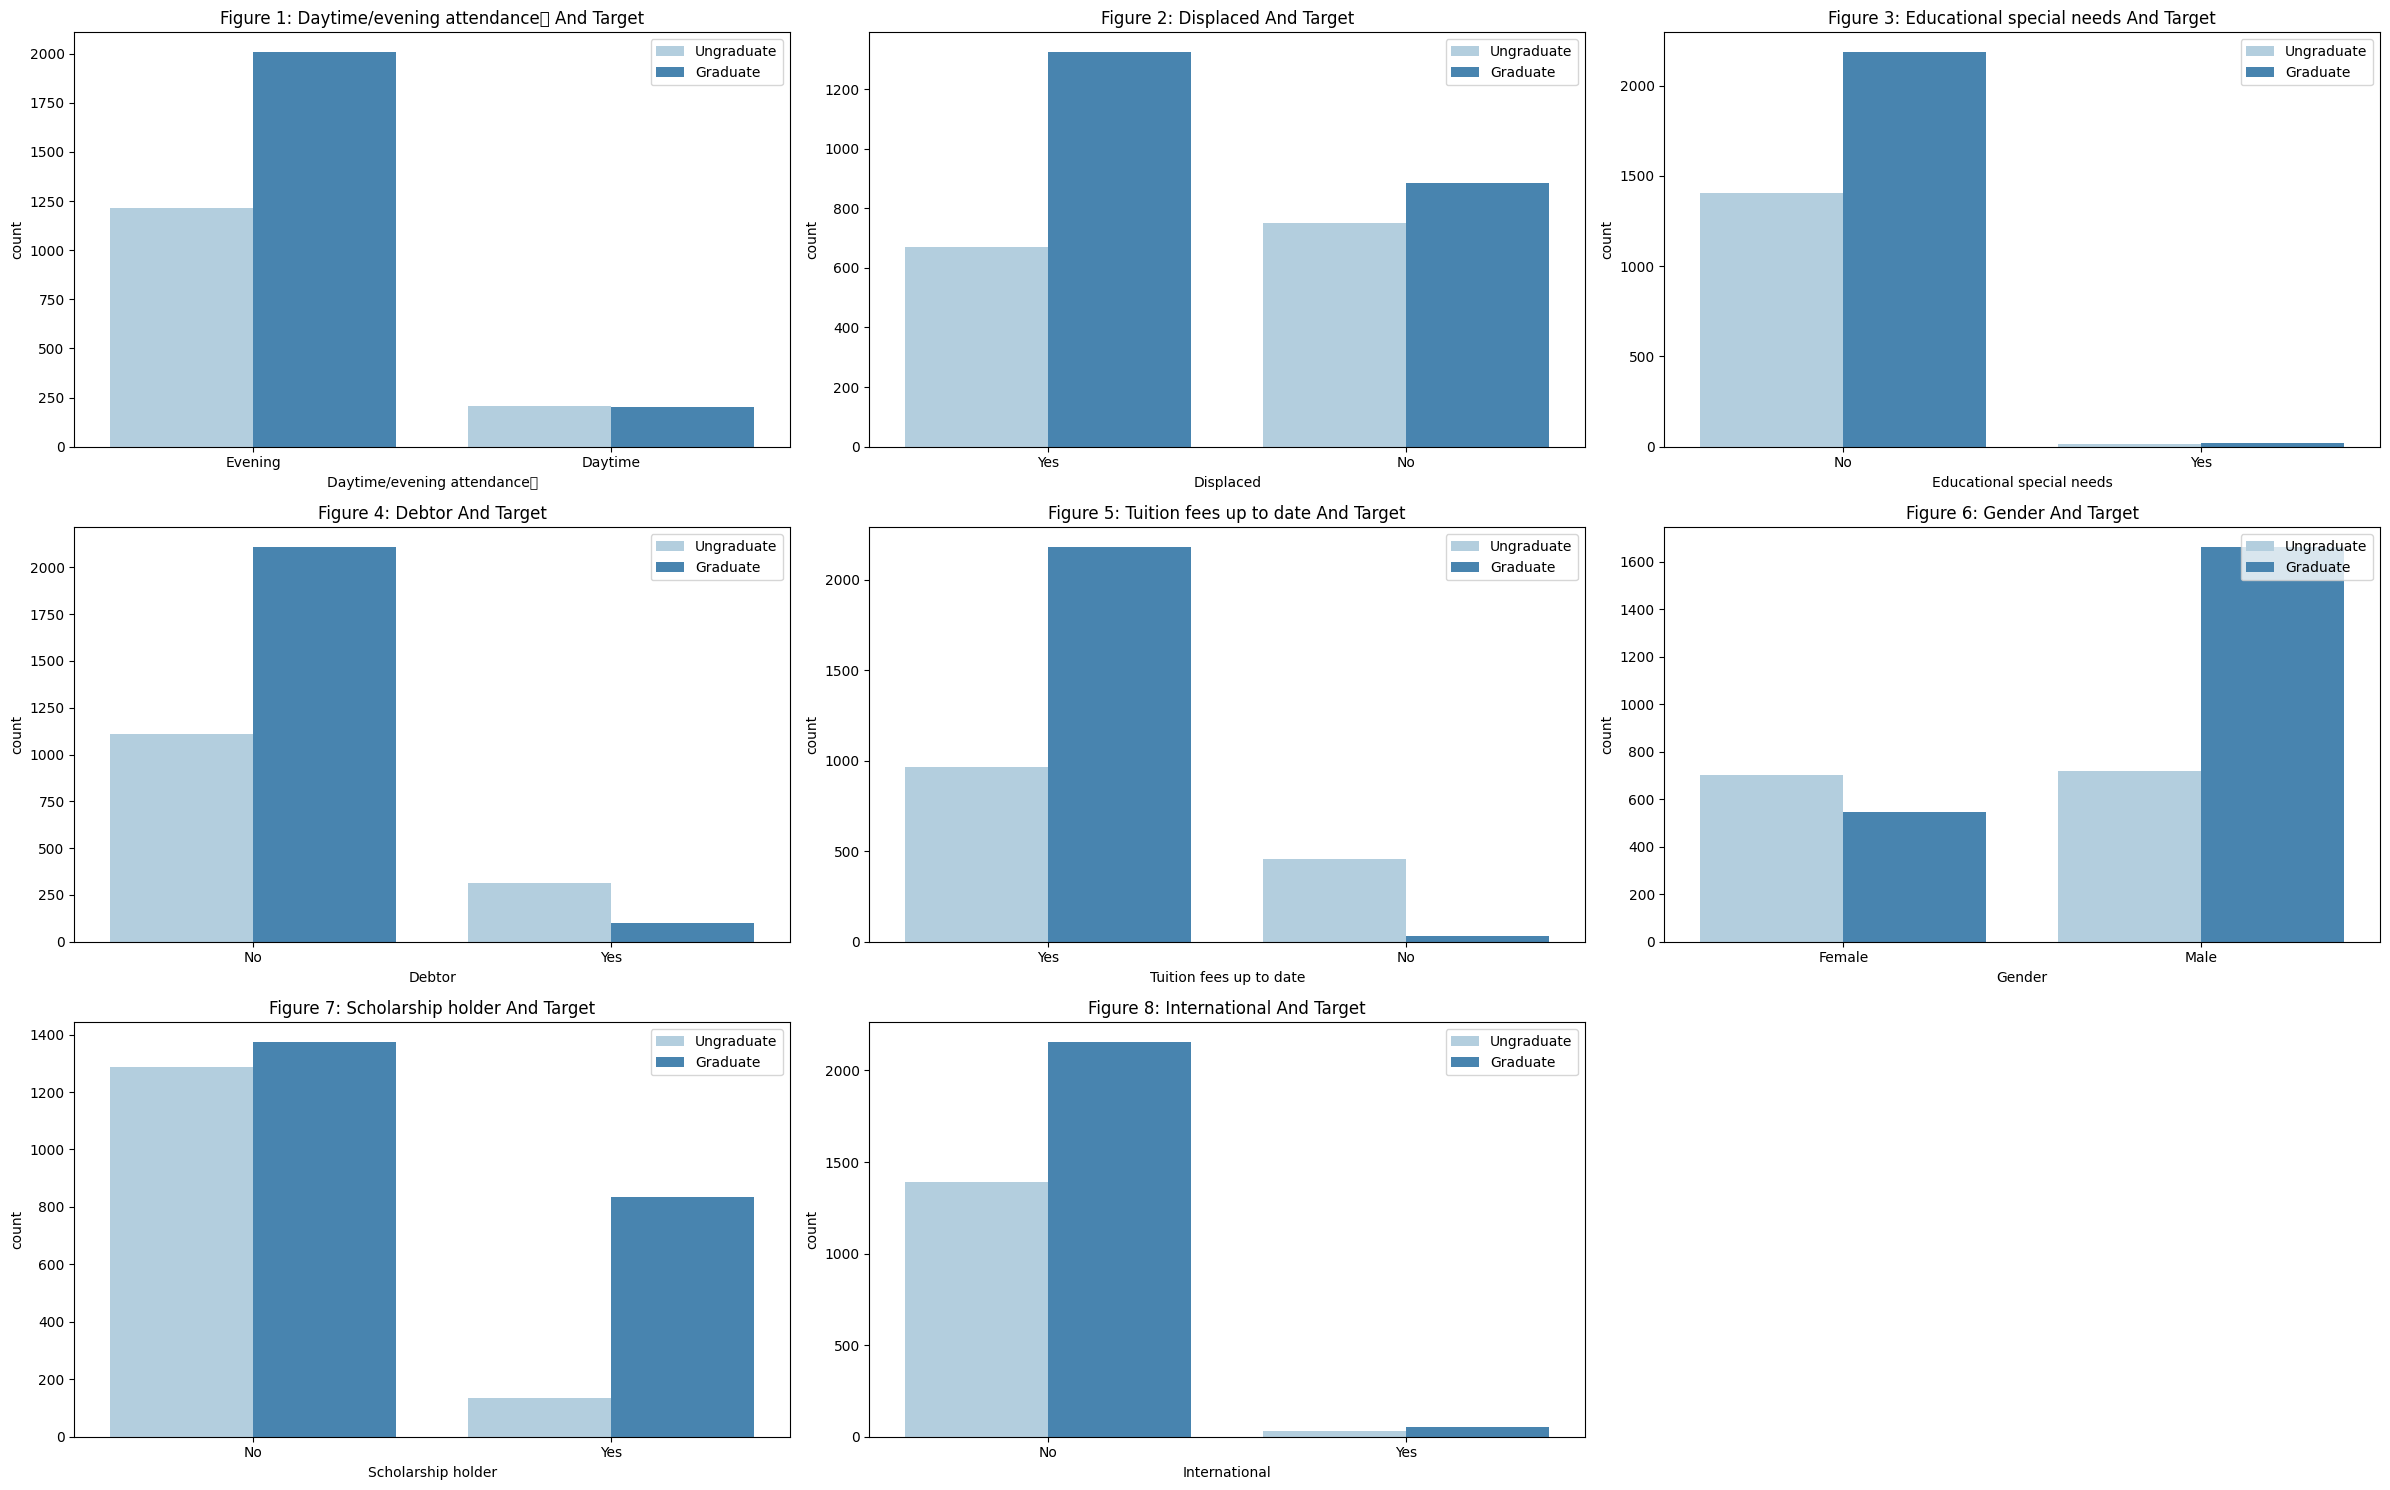

In [ ]:
def visulize_bars(df: pd.DataFrame):
    label = 'Target'
    columns_two = list(df.columns)
    columns_two.remove(label)

    n_rows = 3
    n_cols = 3

    fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_rows * 8, n_cols * 5))

    for row in range(0, n_rows):
        for col in range(0, n_cols):
            i = row*n_cols + col
            if i < len(columns_two):
                ax_i = ax[row, col]
                sns.countplot(data = df, x = columns_two[i], hue = 'Target', palette = 'Blues', ax = ax_i)
                ax_i.set_title(f"Figure {i+1}: {columns_two[i]} And {label}")
                ax_i.legend(title = '', loc = 'upper right', labels = ['Ungraduate', 'Graduate'])
            else:
                ax[row, col].set_visible(False)
    plt.tight_layout()
    plt.show()

visulize_bars(prepare_to_bars(df_category_two.copy()))

## Biến phân loại nhiều giá trị

In [ ]:
def statistical_category(df: pd.DataFrame):
    columns = list(df.columns)
    for i in range(len(columns)):
        freqs = calculate_frequency(df[columns[i]])
        settings = setup_labels(columns[i])
        if columns[i] != 'Application order':
            freqs['Value'] = freqs['Value'].replace(settings)
        print(f"Sự phân bổ giá trị phân loại trong thuộc tính {columns[i]}")
        print(freqs)
        print("-"*70)

statistical_category(df_category_remaining)

Sự phân bổ giá trị phân loại trong thuộc tính Marital status
               Value  Frequency
0             single   0.881267
1            married   0.090083
2           divorced   0.020661
3        facto union   0.006061
4  legally separated   0.001377
5            widower   0.000551
----------------------------------------------------------------------
Sự phân bổ giá trị phân loại trong thuộc tính Application mode
                                                Value  Frequency
0                      1st phase - general contingent   0.387879
1                      2nd phase - general contingent   0.196419
2                                   Over 23 years old   0.182920
3                                    Change of course   0.065289
4        Technological specialization diploma holders   0.043251
5                     Holders of other higher courses   0.036364
6                      3rd phase - general contingent   0.029752
7                                            Transfer   0.018

## Biến kiểu số (biến liên tục)

In [ ]:
def visualize_hists(df: pd.DataFrame, num_cols):
    df['Target'] = df['Target'].replace({0: 'Ungraduate', 1: 'Graduate'})

    n_rows = 3
    n_cols = 3

    fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_rows * 8, n_cols * 5))

    for row in range(0, n_rows):
        for col in range(0, n_cols):
            i = row*n_cols + col
            if i < len(num_cols):
                ax_i = ax[row, col]
                sns.histplot(data = df, x = num_cols[i], hue='Target', kde = True, bins = 40, ax = ax_i)
                ax_i.set_title(f"Figure {i+1}: Biểu đồ phân bổ của biến {num_cols[i]}")
            else:
                ax[row, col].set_visible(False)
    plt.tight_layout()
    plt.show()

def visualize_boxplots(df: pd.DataFrame, num_cols):
    df['Target'] = df['Target'].replace({0: 'Ungraduate', 1: 'Graduate'})

    n_rows = 3
    n_cols = 3

    fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_rows * 8, n_cols * 5))

    for row in range(0, n_rows):
        for col in range(0, n_cols):
            i = row*n_cols + col
            if i < len(num_cols):
                ax_i = ax[row, col]
                sns.boxplot(data = df, x = num_cols[i], hue='Target', ax = ax_i)
                ax_i.set_title(f"Figure {i+1}: Biểu đồ BoxPlot của biến {num_cols[i]}")
            else:
                ax[row, col].set_visible(False)
    plt.tight_layout()
    plt.show()

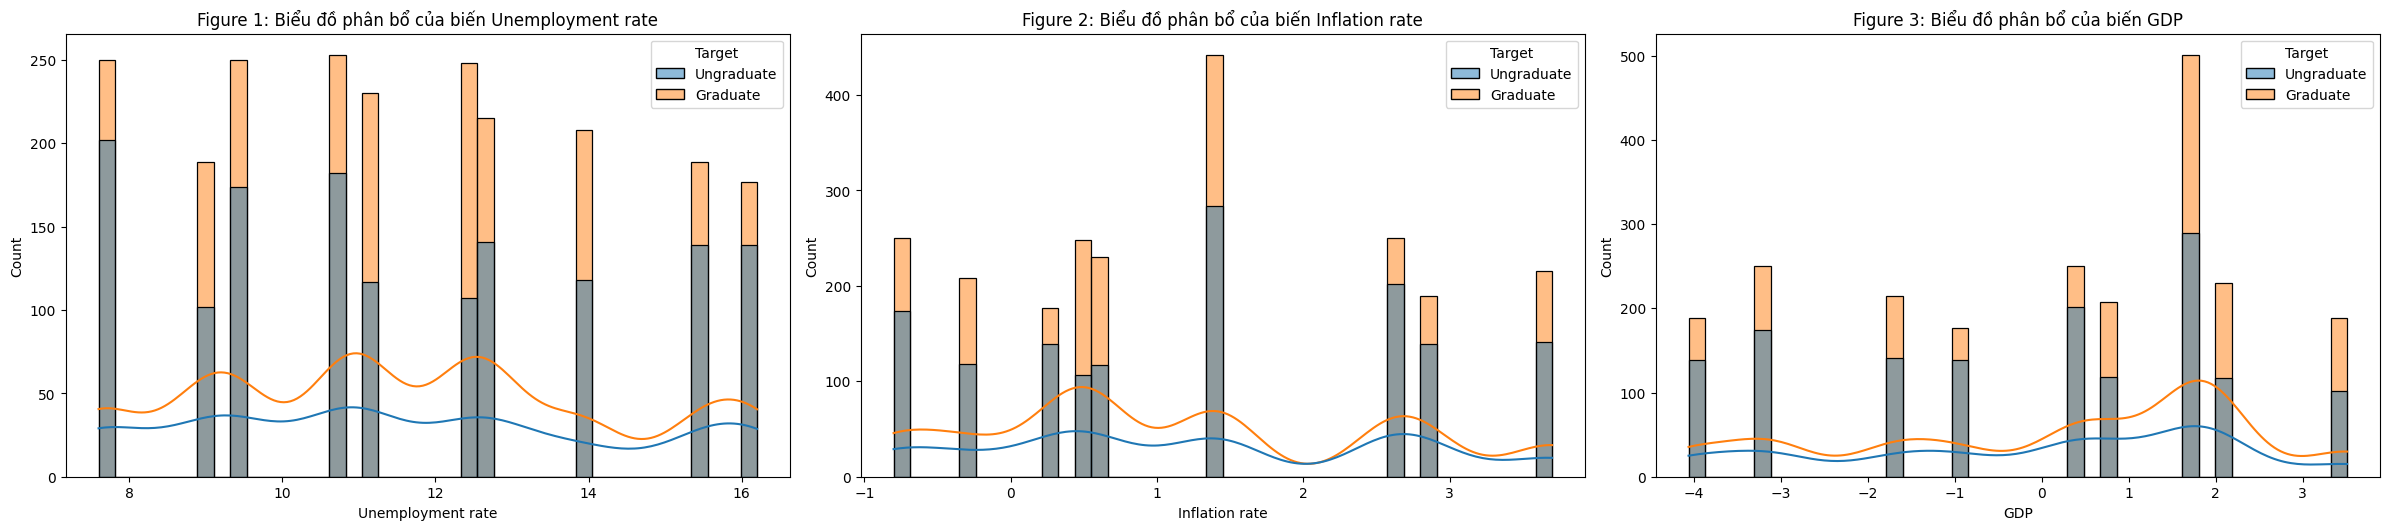

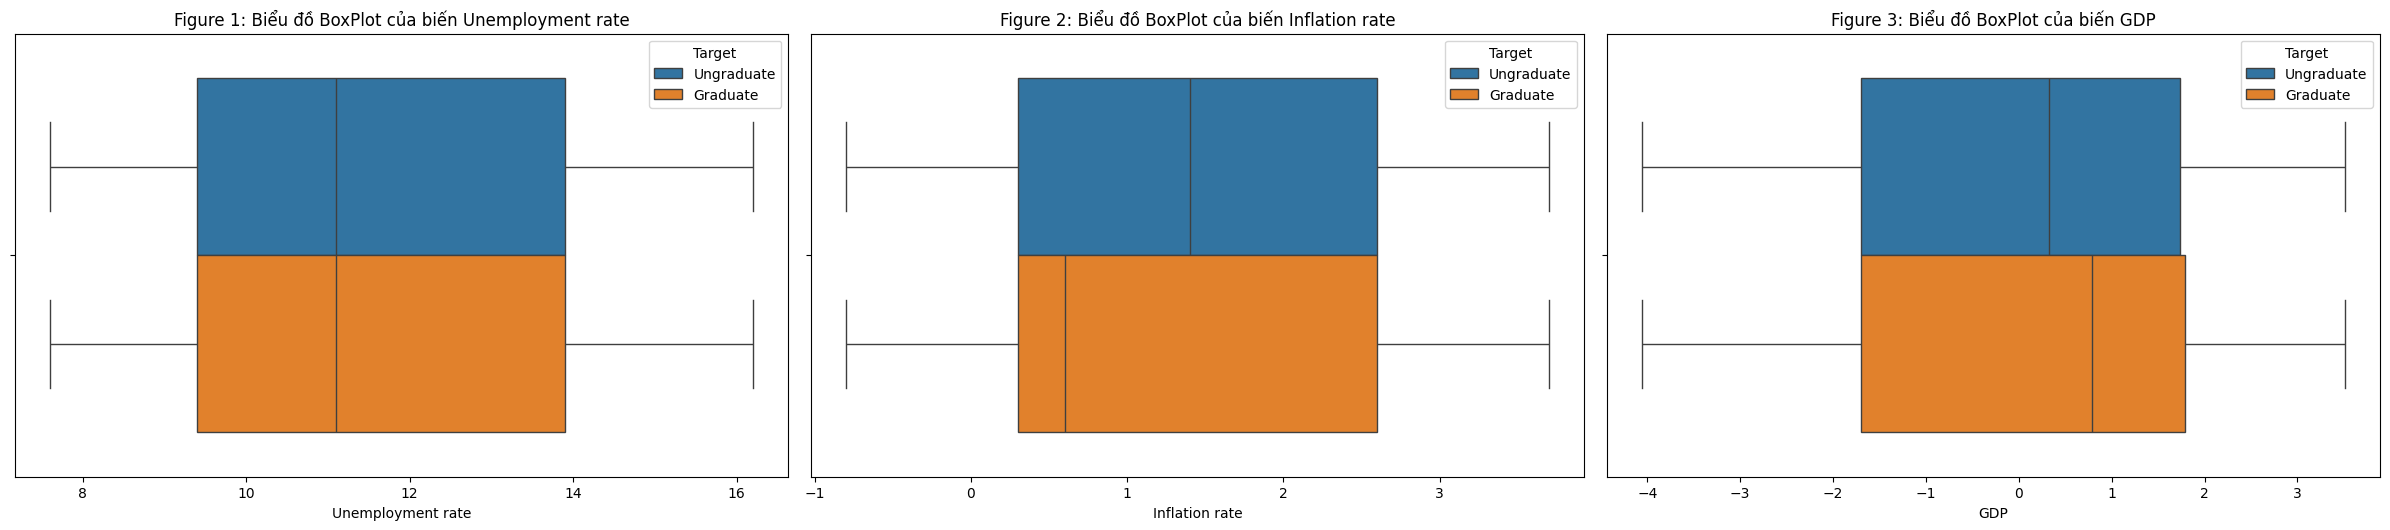

In [ ]:
# Sự ảnh hưởng yếu tố kinh tế (thất nghiệp, lạm phát và GDP) đến biến mục tiêu Target
visualize_hists(data.copy(), num_cols=['Unemployment rate', 'Inflation rate', 'GDP'])
visualize_boxplots(data.copy(), num_cols=['Unemployment rate', 'Inflation rate', 'GDP'])

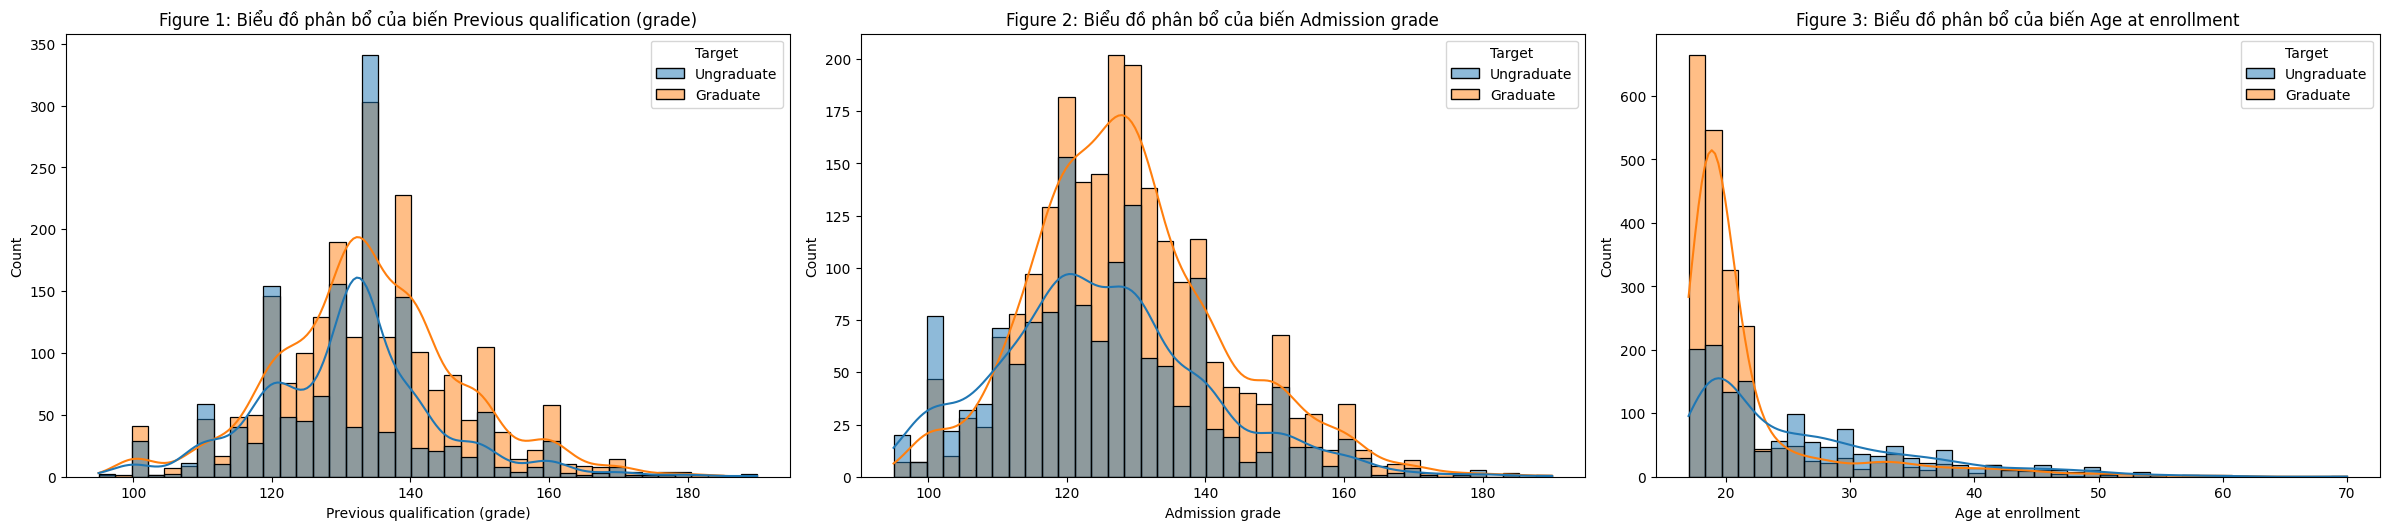

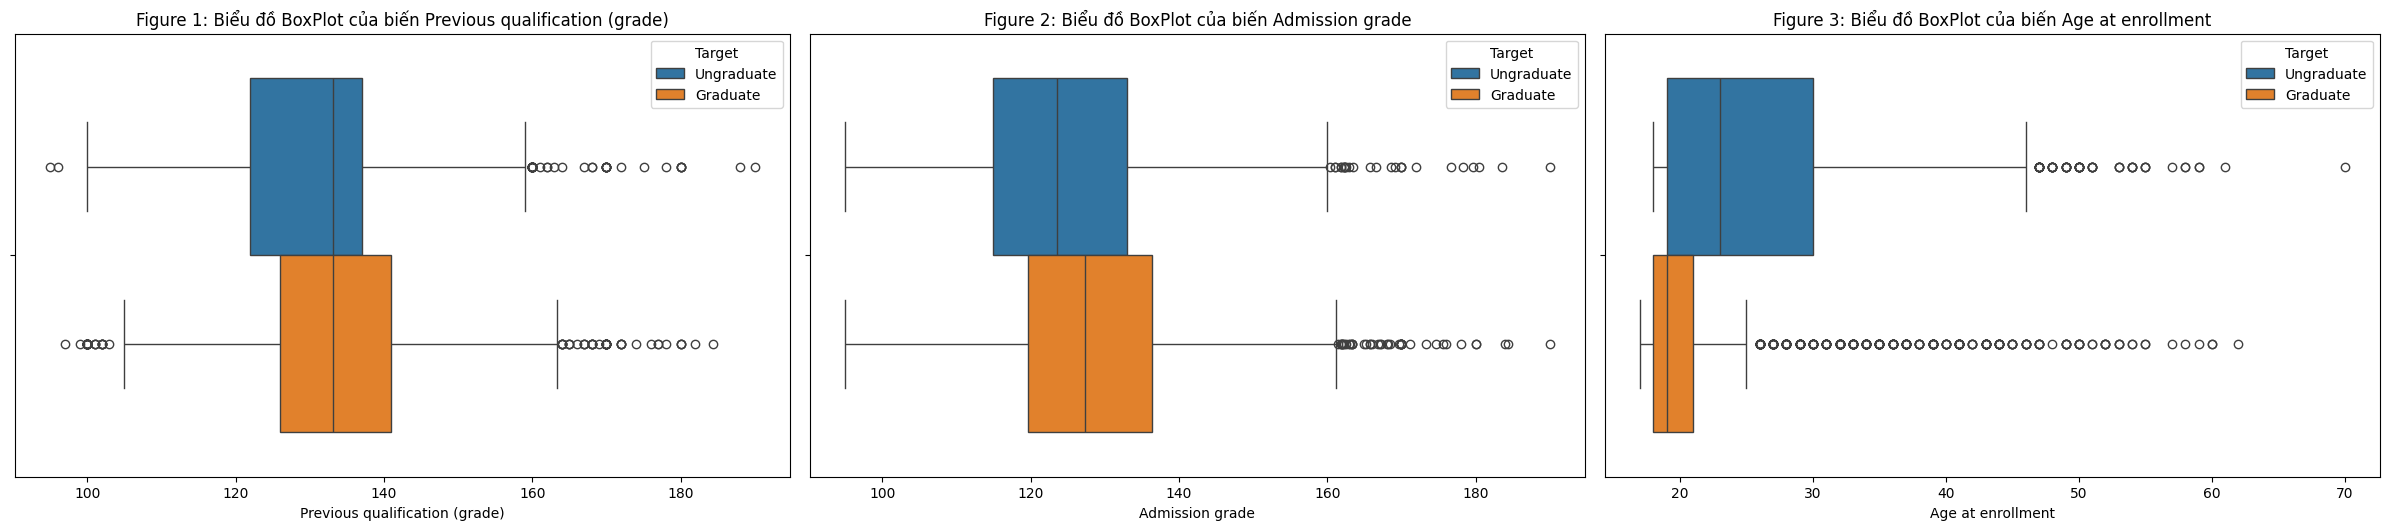

In [ ]:
# Sự ảnh hưởng bởi tuổi tác và trình độ trước khi nhập học đến biến mục tiêu Target
visualize_hists(data.copy(), num_cols=['Previous qualification (grade)', 'Admission grade', 'Age at enrollment'])
visualize_boxplots(data.copy(), num_cols=['Previous qualification (grade)', 'Admission grade', 'Age at enrollment'])

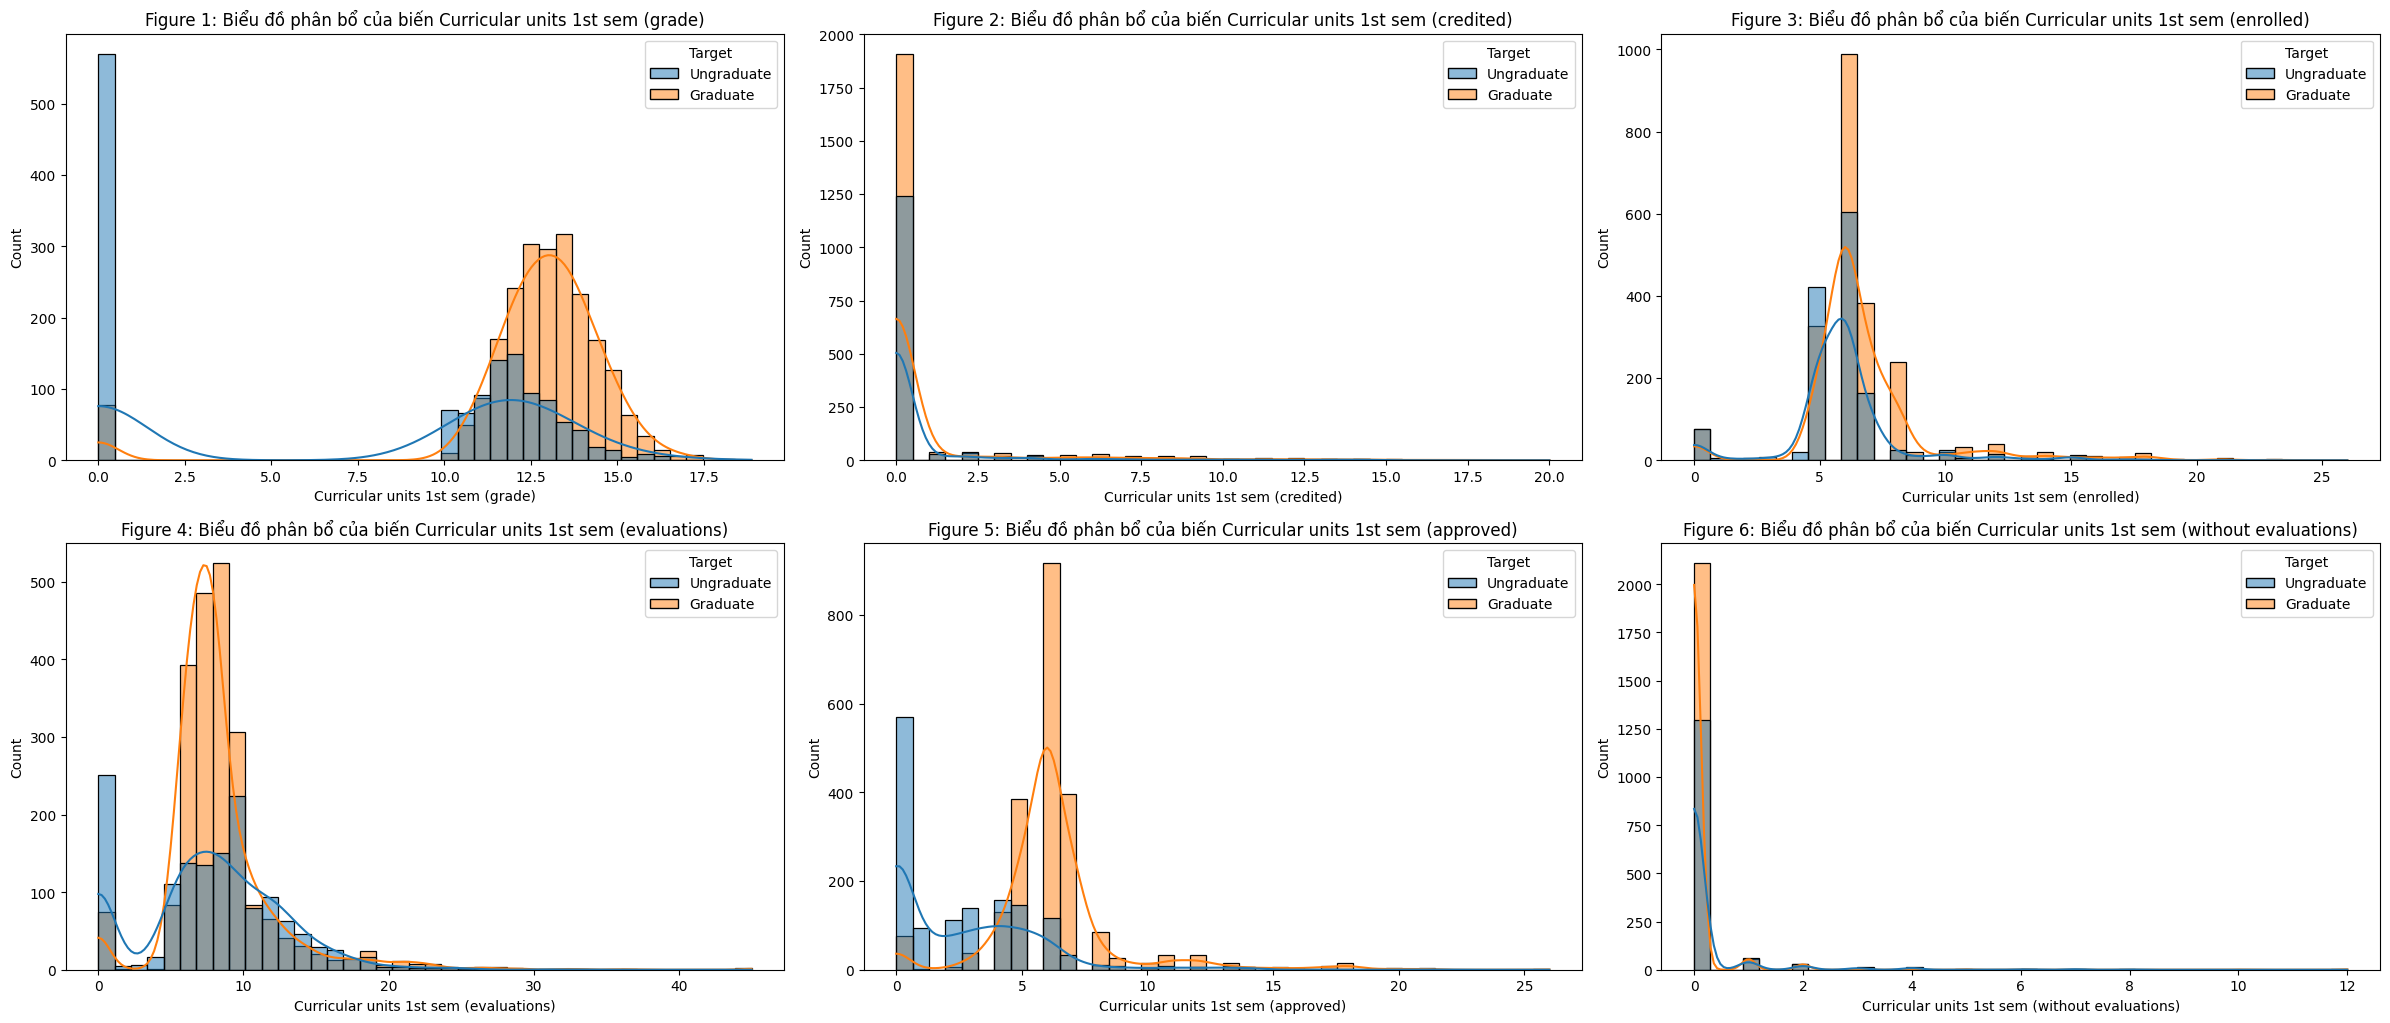

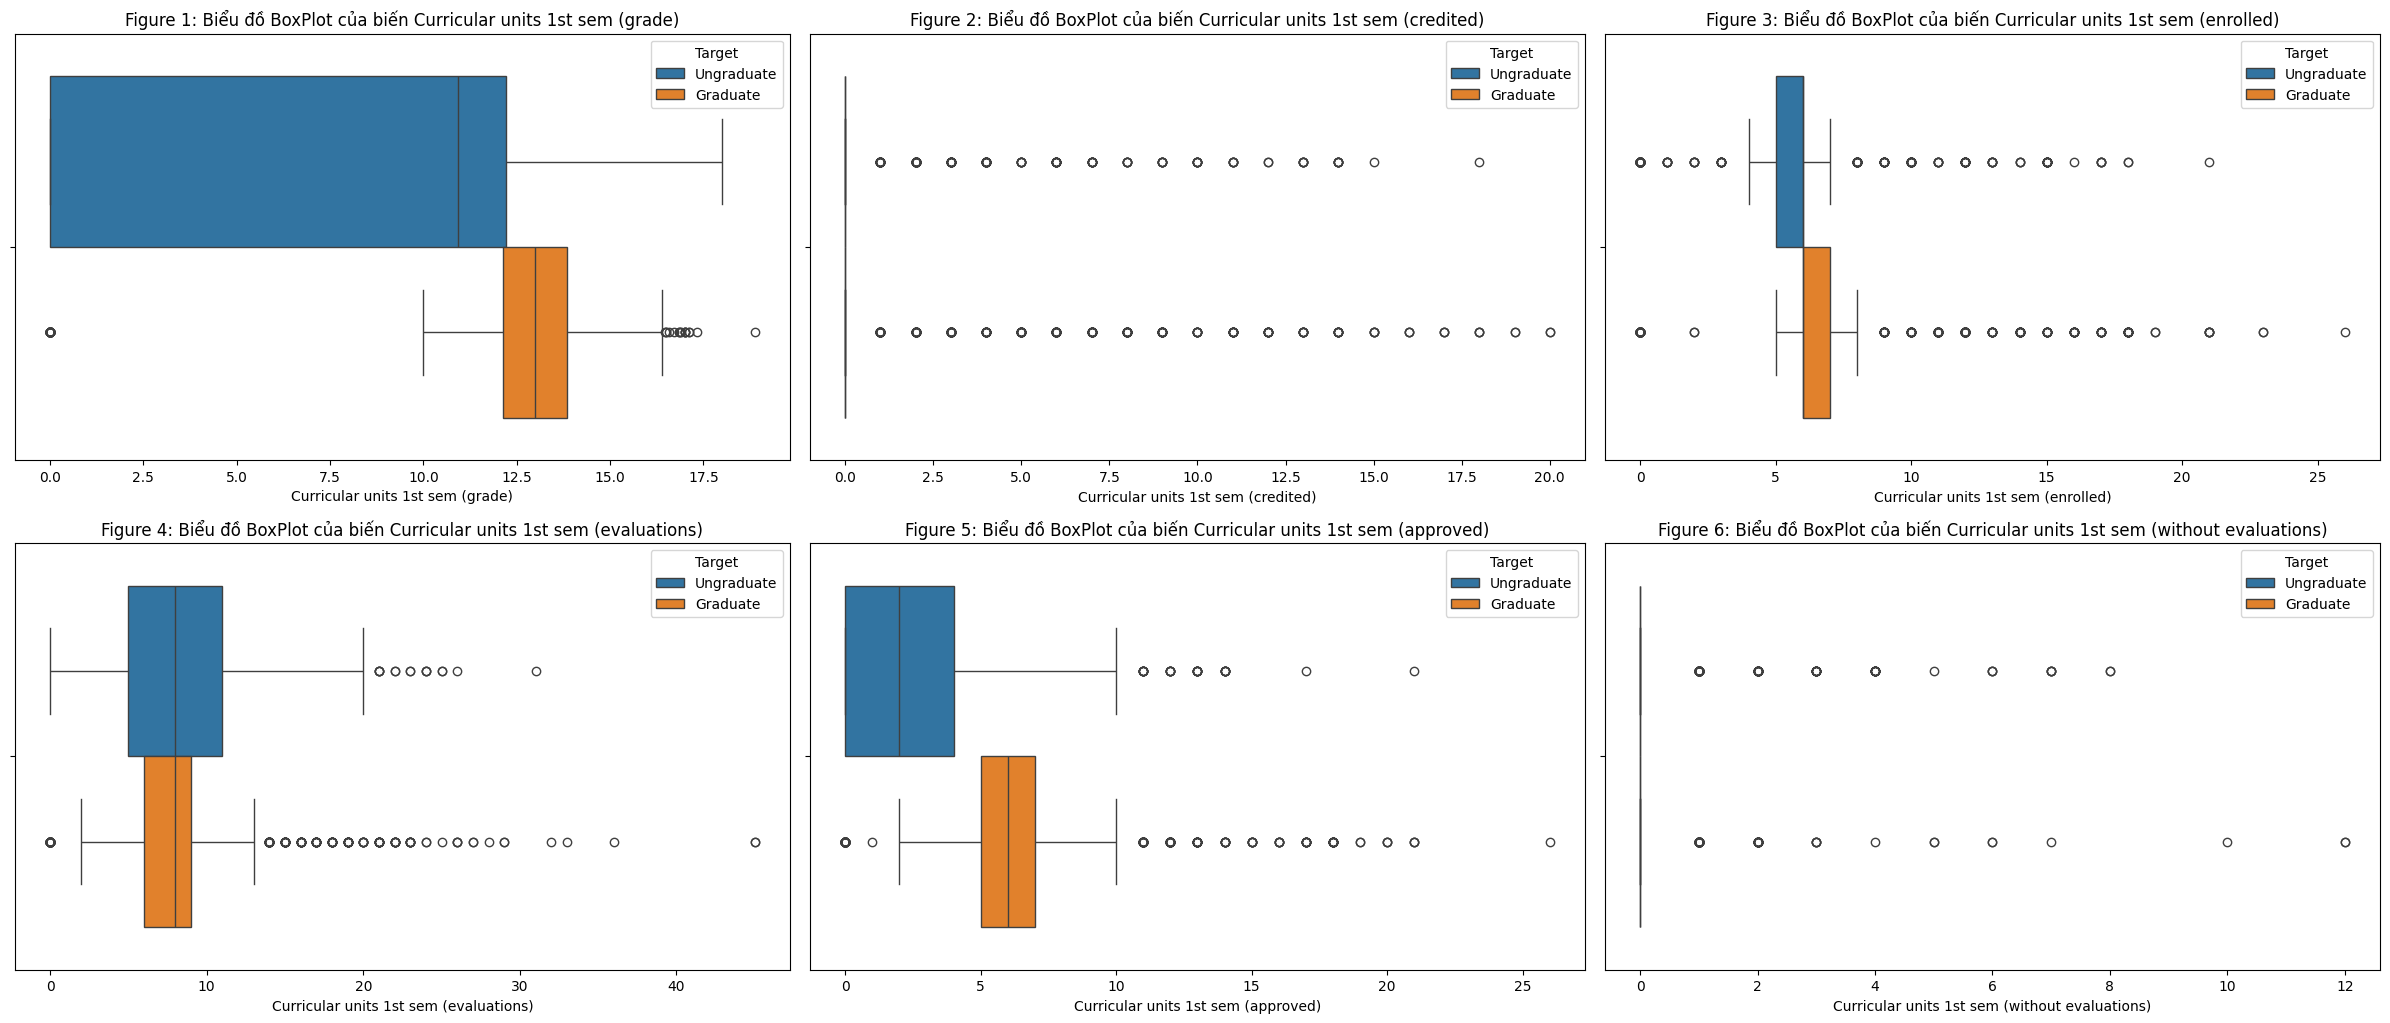

In [ ]:
# Sự ảnh hưởng bởi kết quả học tập trong học kì 1 đến biến mục tiêu Target
visualize_hists(data.copy(),
                num_cols=['Curricular units 1st sem (grade)', 'Curricular units 1st sem (credited)',
                          'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)',
                          'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)']
)

visualize_boxplots(data.copy(),
                   num_cols=['Curricular units 1st sem (grade)', 'Curricular units 1st sem (credited)',
                             'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)',
                             'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)']
)

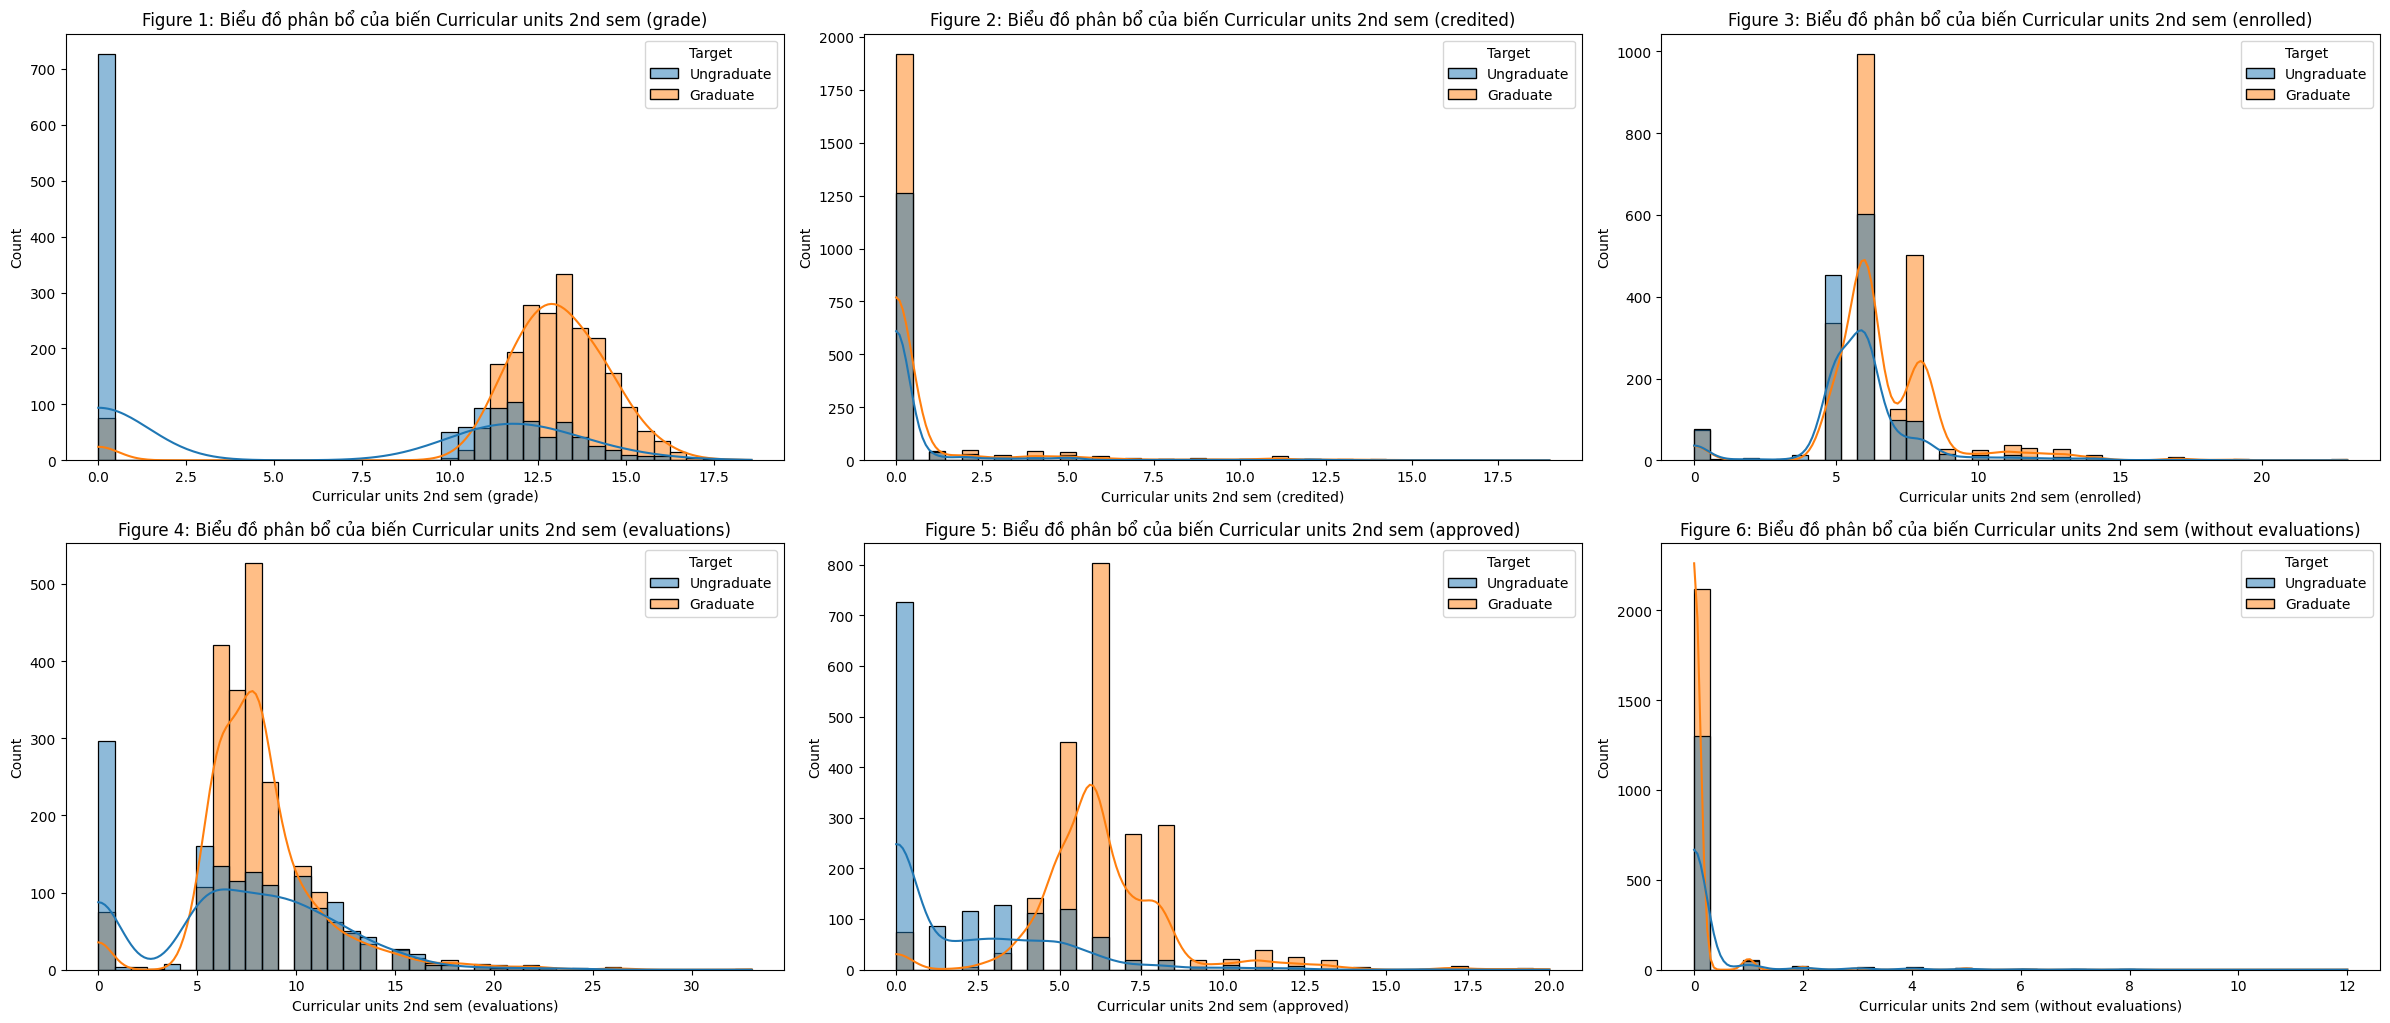

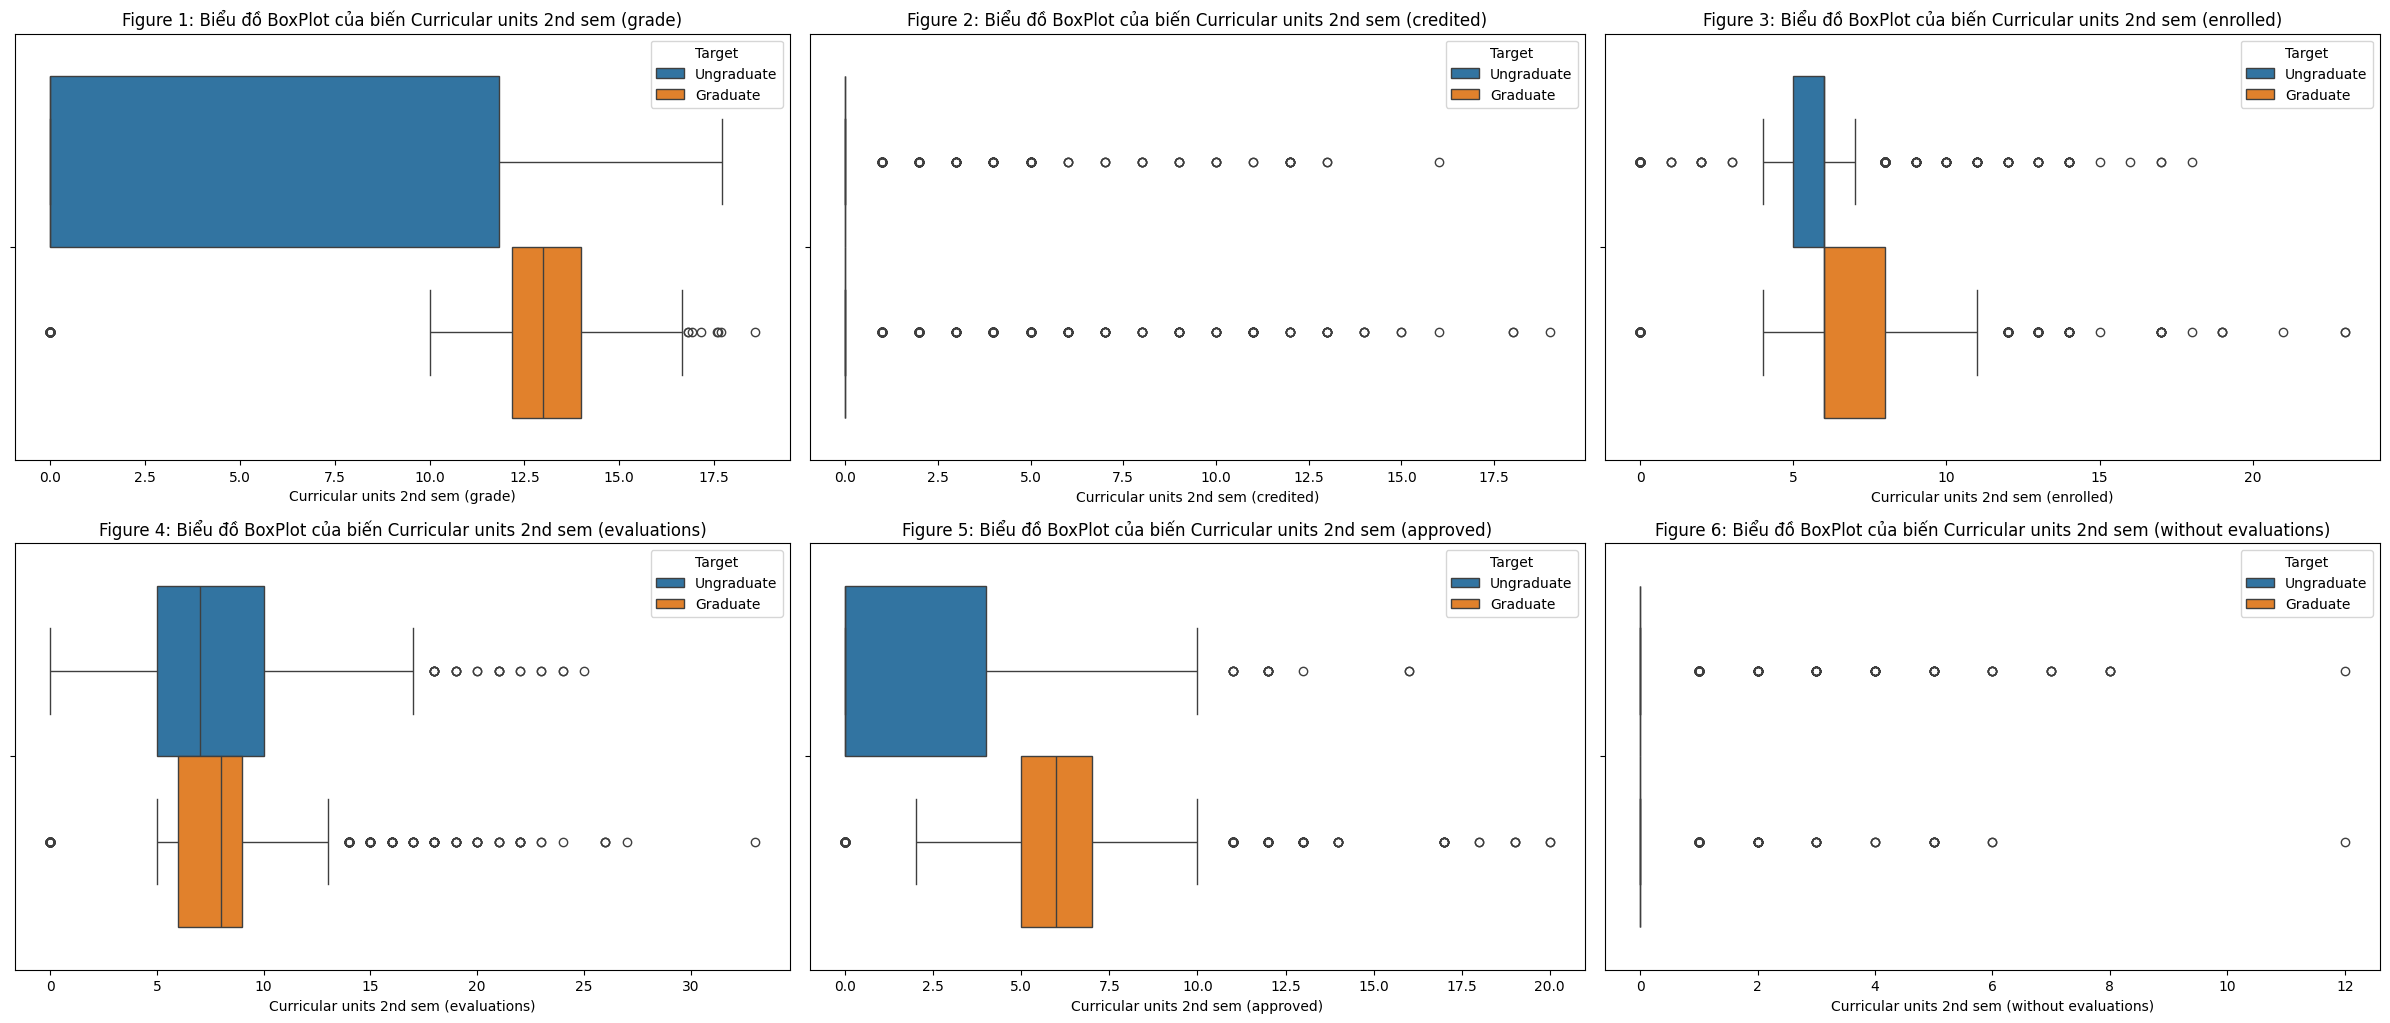

In [ ]:
# Sự ảnh hưởng bởi kết quả học tập trong học kì 2 đến biến mục tiêu Target
visualize_hists(data.copy(),
                num_cols=['Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (credited)',
                          'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)',
                          'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (without evaluations)']
)

visualize_boxplots(data.copy(),
                   num_cols=['Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (credited)',
                             'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)',
                             'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (without evaluations)']
)

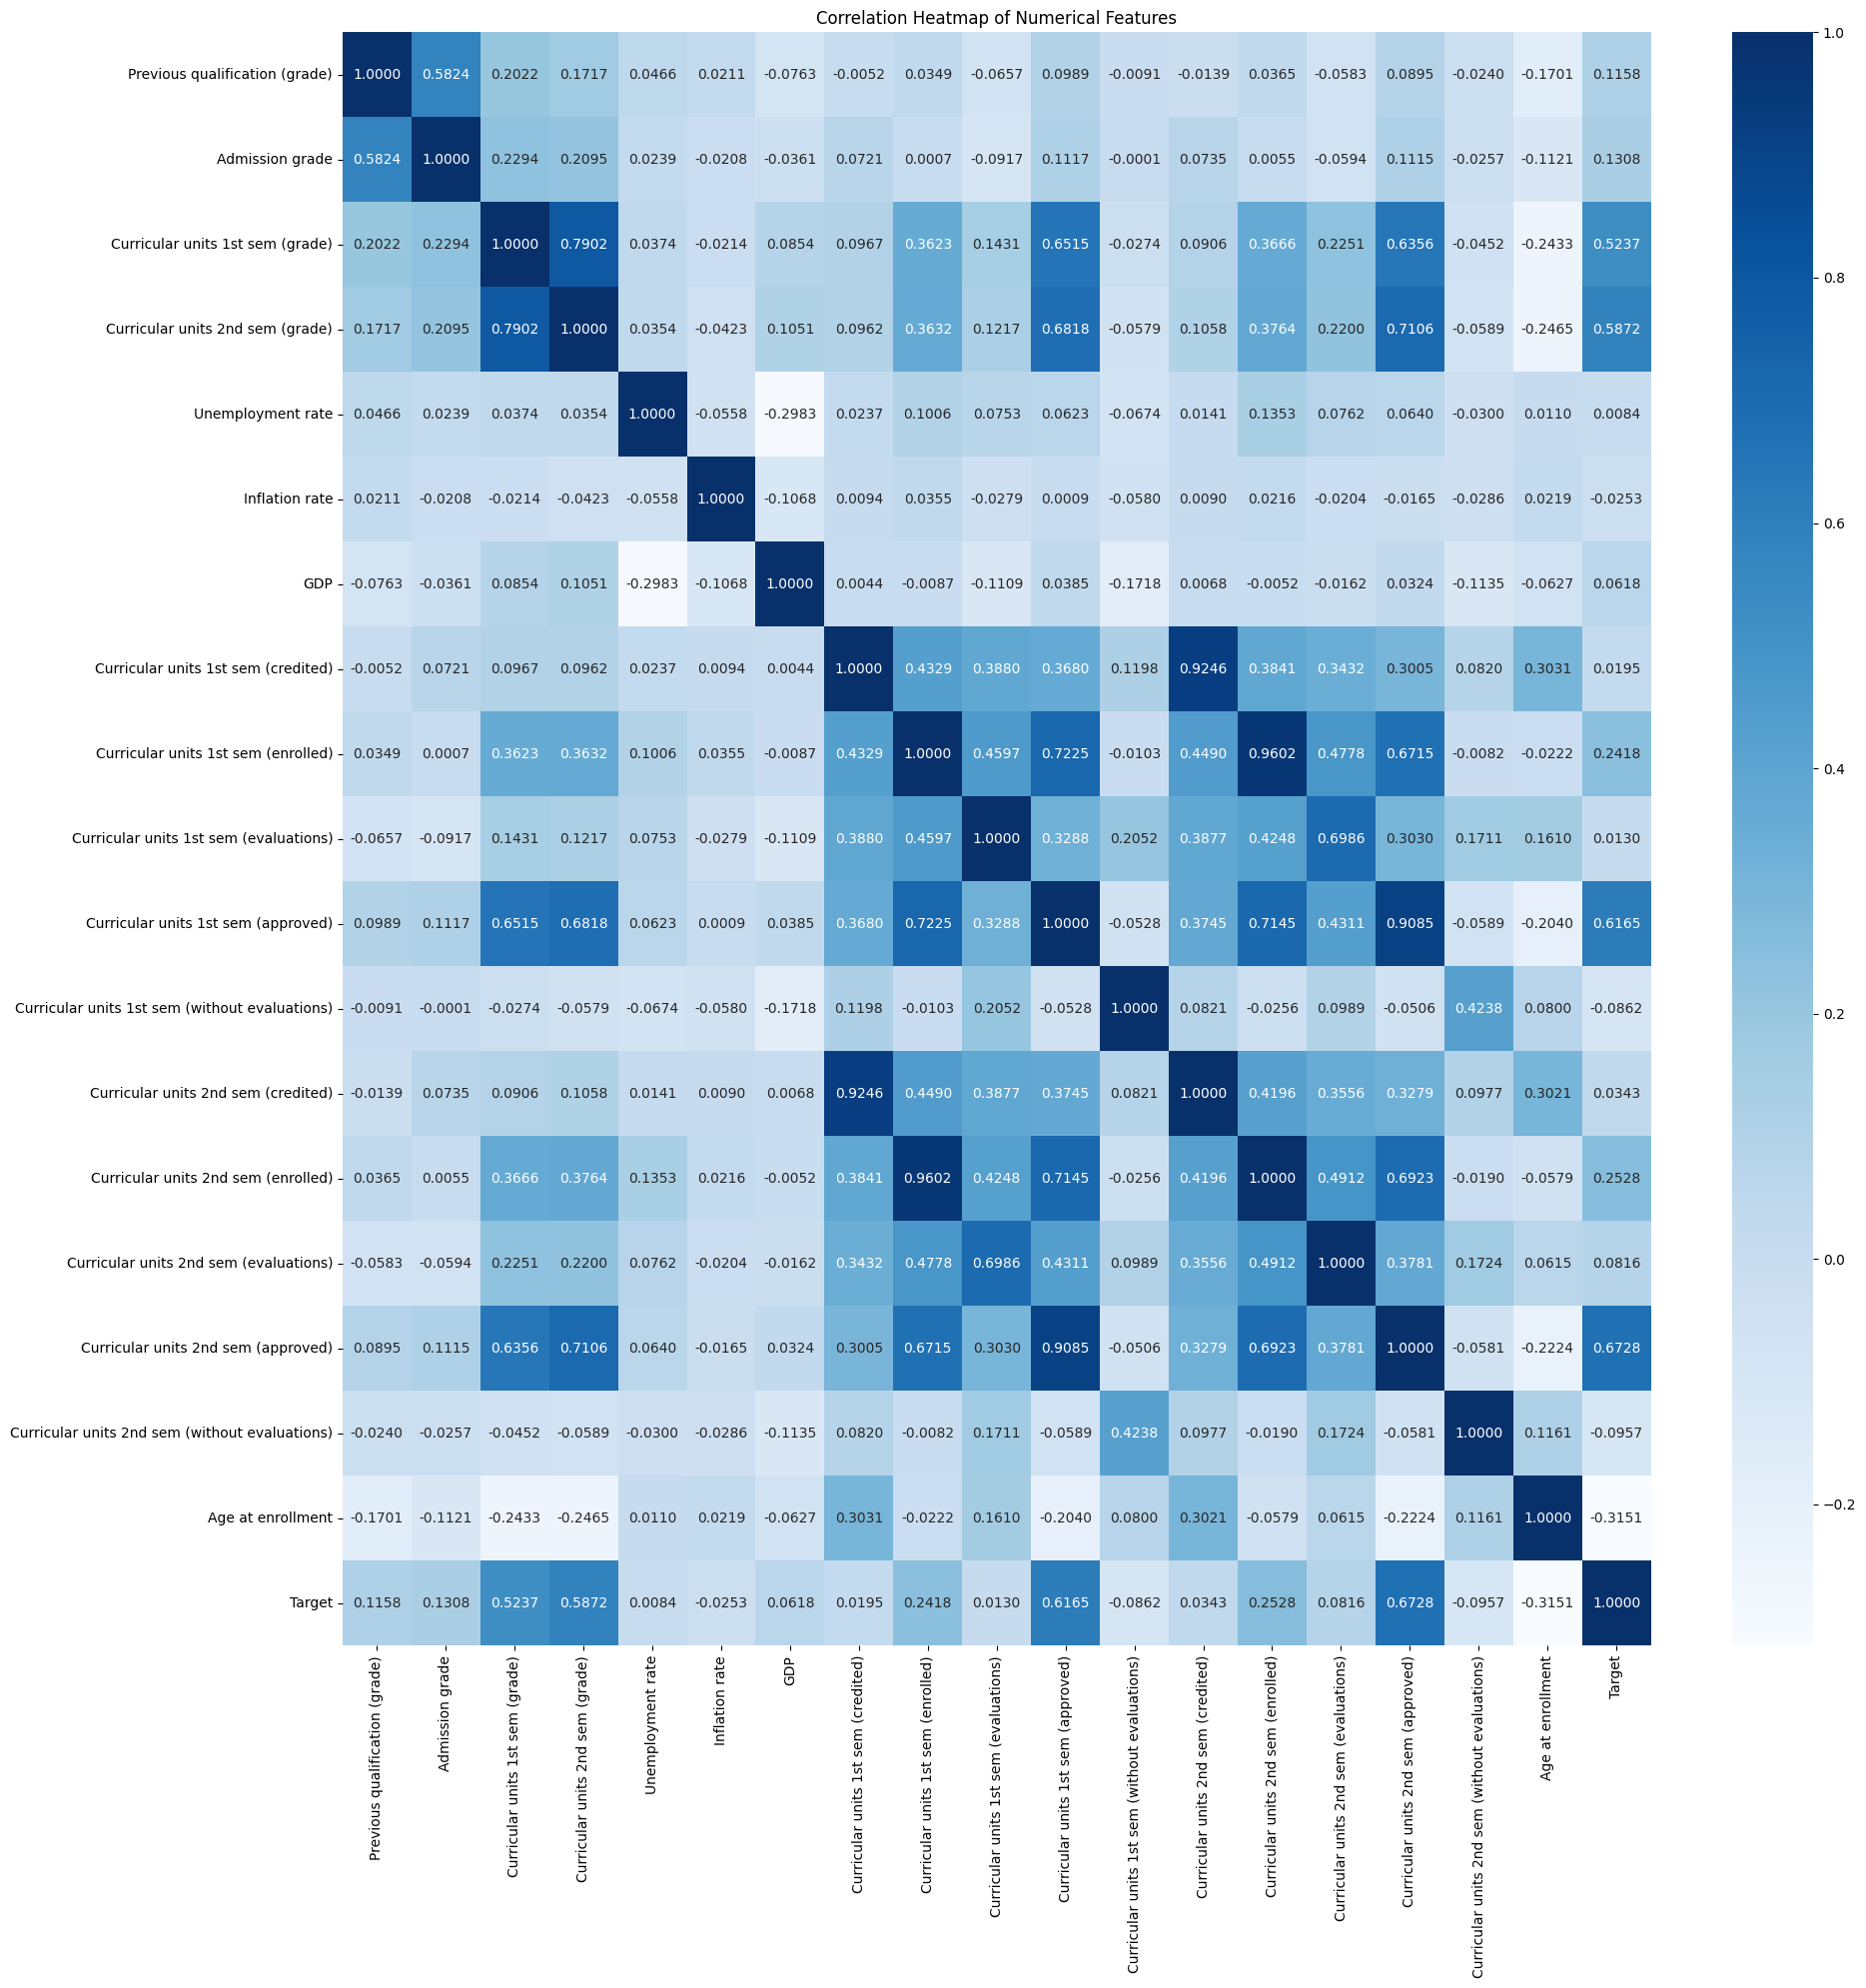

In [ ]:
plt.figure(figsize = (20, 20))
sns.heatmap(df_nums.corr(method='spearman'), cmap = "Blues", annot = True, fmt=".4f")
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

Quan sát heatmap -> hiện tượng đa cộng tuyến (tương quan mạnh giữa hai biến độc lập) xảy ra giữa các đặc trưng liên quan đến học phần kì 1 và kì 2

# Kiểm định

## Biến phân loại

In [ ]:
# Kiểm định Chi-Squared
def Chi2_categorical_features(df: pd.DataFrame):
    features = []
    p_values = []
    chi2_stats = []
    for col in df.columns:
        if col == 'Target':
            continue
        contingency_table = pd.crosstab(df[col], df['Target'])
        chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

        if p_value < 0.05:
            print(f"Có sự tác động của biến {col.strip()} lên biến mục tiêu Target!")
            features.append(col)
            p_values.append(p_value)
            chi2_stats.append(chi2_stat)
        else:
            print(f"Không có sự tác động của biến {col.strip()} lên biến mục tiêu Target!")
    return pd.DataFrame({
        'Categorical_Features': features,
        'Statistical': chi2_stats,
        'P-Value': p_values
    })

In [ ]:
categorical_df = Chi2_categorical_features(df_cates)
print(categorical_df)
categorical_cols = list(categorical_df['Categorical_Features'])

Có sự tác động của biến Marital status lên biến mục tiêu Target!
Có sự tác động của biến Application mode lên biến mục tiêu Target!
Có sự tác động của biến Application order lên biến mục tiêu Target!
Có sự tác động của biến Course lên biến mục tiêu Target!
Có sự tác động của biến Daytime/evening attendance lên biến mục tiêu Target!
Có sự tác động của biến Previous qualification lên biến mục tiêu Target!
Không có sự tác động của biến Nacionality lên biến mục tiêu Target!
Có sự tác động của biến Mother's qualification lên biến mục tiêu Target!
Có sự tác động của biến Father's qualification lên biến mục tiêu Target!
Có sự tác động của biến Mother's occupation lên biến mục tiêu Target!
Có sự tác động của biến Father's occupation lên biến mục tiêu Target!
Có sự tác động của biến Displaced lên biến mục tiêu Target!
Không có sự tác động của biến Educational special needs lên biến mục tiêu Target!
Có sự tác động của biến Debtor lên biến mục tiêu Target!
Có sự tác động của biến Tuition fees up 

## Biến kiểu số

In [ ]:
def corr_numerical_features(df: pd.DataFrame, alpha: float = 0.05, threshold: float = 0.2):
    features = []
    p_values = []
    corr_values = []
    for col in df.columns:
        if col == 'Target':
            continue
        corr, p_value = stats.spearmanr(df['Target'], df[col])
        if p_value >= alpha:
            print(f"Không có ý nghĩa thống kê của biến độc lập {col} tác động đến biến phụ thuộc Target!")
            continue
        if abs(corr) >= threshold:
            print(f"Có sự tương quan giữa biến độc lập {col} và biến phụ thuộc Target!")
            features.append(col)
            p_values.append(p_value)
            corr_values.append(corr)
        else:
            print(f"Không có sự tương quan giữa biến độc lập {col} và biến phụ thuộc Target!")
    return pd.DataFrame({
        'Numerical_Features': features,
        'Correlation': corr_values,
        'P-Value': p_values
    })

In [ ]:
corr_numerical_features(df_nums)

Không có sự tương quan giữa biến độc lập Previous qualification (grade) và biến phụ thuộc Target!
Không có sự tương quan giữa biến độc lập Admission grade và biến phụ thuộc Target!
Có sự tương quan giữa biến độc lập Curricular units 1st sem (grade) và biến phụ thuộc Target!
Có sự tương quan giữa biến độc lập Curricular units 2nd sem (grade) và biến phụ thuộc Target!
Không có ý nghĩa thống kê của biến độc lập Unemployment rate tác động đến biến phụ thuộc Target!
Không có ý nghĩa thống kê của biến độc lập Inflation rate tác động đến biến phụ thuộc Target!
Không có sự tương quan giữa biến độc lập GDP và biến phụ thuộc Target!
Không có ý nghĩa thống kê của biến độc lập Curricular units 1st sem (credited) tác động đến biến phụ thuộc Target!
Có sự tương quan giữa biến độc lập Curricular units 1st sem (enrolled) và biến phụ thuộc Target!
Không có ý nghĩa thống kê của biến độc lập Curricular units 1st sem (evaluations) tác động đến biến phụ thuộc Target!
Có sự tương quan giữa biến độc lập Curr

Numerical_Features  Correlation        P-Value
0     Curricular units 1st sem (grade)     0.523679  7.606312e-255
1     Curricular units 2nd sem (grade)     0.587241   0.000000e+00
2  Curricular units 1st sem (enrolled)     0.241820   1.845350e-49
3  Curricular units 1st sem (approved)     0.616451   0.000000e+00
4  Curricular units 2nd sem (enrolled)     0.252826   4.767346e-54
5  Curricular units 2nd sem (approved)     0.672831   0.000000e+00
6                    Age at enrollment    -0.315083   1.782268e-84

In [ ]:
# Create Avg of two feature having multicollinearity
selected_numeric_df = pd.DataFrame()
selected_numeric_df['Age at enrollment'] = df_nums['Age at enrollment']
selected_numeric_df['avg_Grade'] = df_nums[['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']].mean(axis=1)
selected_numeric_df['avg_Enrolled'] = df_nums[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)']].mean(axis=1)
selected_numeric_df['avg_Approved'] = df_nums[['Curricular units 1st sem (approved)', 'Curricular units 2nd sem (approved)']].mean(axis=1)
selected_numeric_df['Target'] = df_nums['Target']

In [ ]:
numerical_df = corr_numerical_features(selected_numeric_df)
print(numerical_df)
numerical_cols = list(numerical_df['Numerical_Features'])

Có sự tương quan giữa biến độc lập Age at enrollment và biến phụ thuộc Target!
Có sự tương quan giữa biến độc lập avg_Grade và biến phụ thuộc Target!
Có sự tương quan giữa biến độc lập avg_Enrolled và biến phụ thuộc Target!
Có sự tương quan giữa biến độc lập avg_Approved và biến phụ thuộc Target!
  Numerical_Features  Correlation       P-Value
0  Age at enrollment    -0.315083  1.782268e-84
1          avg_Grade     0.600147  0.000000e+00
2       avg_Enrolled     0.252743  5.173240e-54
3       avg_Approved     0.657345  0.000000e+00


In [ ]:
model_df = pd.concat((data[categorical_cols], selected_numeric_df), axis=1)

In [ ]:
model_df[(model_df['avg_Approved'] == 0) & (model_df['Target'] == 1)]

Marital status  Application mode  Application order  Course  \
18                 1                 1                  3     171   
51                 1                 1                  3     171   
79                 1                 1                  4     171   
330                1                 1                  1     171   
434                1                39                  1     171   
...              ...               ...                ...     ...   
3234               1                17                  2     171   
3517               1                 1                  1     171   
3571               1                 1                  1     171   
3581               1                 1                  2     171   
3585               1                 1                  3     171   

      Daytime/evening attendance\t  Previous qualification  \
18                               1                       1   
51                               1                       1   
79                               1                       1   
330                              1                       1   
434                              1                       1   
...                            ...                     ...   
3234                             1                       1   
3517                             1                       1   
3571                             1                       1   
3581                             1                       1   
3585                             1                       1   

      Mother's qualification  Father's qualification  Mother's occupation  \
18                         1                       1                    9   
51                        19                      19                    5   
79                         1                       1                    9   
330                        1                      19                    3   
434                        3                       1                    2   
...                      ...                     ...                  ...   
3234                       3                       1                    2   
3517                       1                      38                    4   
3571                       3                       1                    4   
3581                      38                      38                    4   
3585                       1                       3                    5   

      Father's occupation  Displaced  Debtor  Tuition fees up to date  Gender  \
18                      8          0       0                        1       0   
51                      3          1       0                        1       1   
79                     10          1       0                        1       0   
330                     9          1       0                        1       0   
434                    10          1       0                        1       1   
...                   ...        ...     ...                      ...     ...   
3234                    6          1       0                        1       0   
3517                    5          1       0                        1       1   
3571                    4          1       0                        1       0   
3581                    9          1       0                        1       1   
3585                    2          1       0                        1       1   

      Scholarship holder  Age at enrollment  avg_Grade  avg_Enrolled  \
18                     1                 21        0.0           0.0   
51                     1                 19        0.0           0.0   
79                     0                 20        0.0           0.0   
330                    0                 18        0.0           0.0   
434                    0                 24        0.0           0.0   
...                  ...                ...        ...           ...   
3234                   1      

In [ ]:
model_df = model_df.drop(model_df[(model_df['avg_Approved'] == 0) & (model_df['Target'] == 1)].index)

# Chuẩn hóa dữ liệu dạng số

In [ ]:
def Stardardization(df: pd.DataFrame, num_features: list):
    for feature in num_features:
        df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
    return df

model_df = Stardardization(model_df, numerical_cols)

# Xây dựng mô hình

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(columns='Target'), model_df['Target'], test_size=0.2, random_state=42)

## Logistic Regression

In [ ]:
def objective(trial):
    C = trial.suggest_int('C', 1, 5)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-30 12:29:46,936] A new study created in memory with name: no-name-943d33ad-9a55-4e49-ba50-bf901f48879c
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

Best hyperparameters: {'C': 2, 'solver': 'liblinear', 'max_iter': 700}
Best cross-validation accuracy: 0.9233520631698804
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       307
           1       0.90      0.96      0.93       404

    accuracy                           0.92       711
   macro avg       0.92      0.91      0.92       711
weighted avg       0.92      0.92      0.92       711



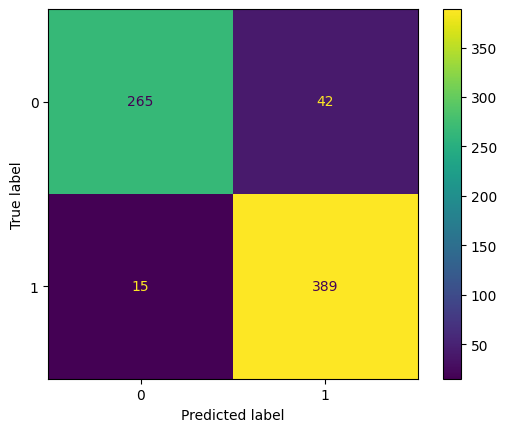

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
best_params = study.best_params
best_model = LogisticRegression(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
class_report = classification_report(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
print(class_report)
display.plot()

## Decision Tree

In [ ]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_categorical('max_depth', [None, 3, 5, 20])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [2, 4, 6])
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_categorical('max_leaf_nodes', [None, 10, 20, 30])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, class_weight=class_weight, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-30 16:28:49,690] A new study created in memory with name: no-name-2c7ec7b3-d636-4c92-b590-64e855651822
[I 2024-11-30 16:28:49,757] Trial 0 finished with value: 0.7243403302061932 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7243403302061932.
[I 2024-11-30 16:28:49,842] Trial 1 finished with value: 0.8941644595163247 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_leaf_nodes': 30, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8941644595163247.
[I 2024-11-30 16:28:49,899] Trial 2 finished with value: 0.8741138394514717 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_leaf_nodes': 20, 'cl

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
best_params = study.best_params
best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

Best hyperparameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_leaf_nodes': None, 'class_weight': None}
Best cross-validation accuracy: 0.9110417337062799
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       307
           1       0.89      0.98      0.93       404

    accuracy                           0.92       711
   macro avg       0.93      0.91      0.91       711
weighted avg       0.92      0.92      0.92       711



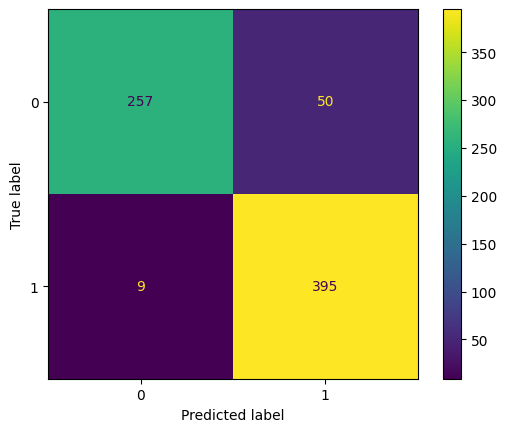

In [ ]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
display.plot()

## Random Forest

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 200])
    criterion = trial.suggest_categorical('criterion', ['gini'])
    max_depth = trial.suggest_categorical('max_depth', [None, 3, 5, 20])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [2, 4, 6])
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_categorical('max_leaf_nodes', [None, 10, 20, 30])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-30 16:35:00,240] A new study created in memory with name: no-name-bbdd9989-ff63-4f08-8747-754e842f36b3
[I 2024-11-30 16:35:01,489] Trial 0 finished with value: 0.9078782890665611 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_leaf_nodes': 10, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9078782890665611.
[I 2024-11-30 16:35:03,162] Trial 1 finished with value: 0.9099897274685016 and parameters: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'class_weight': None}. Best is trial 1 with value: 0.9099897274685016.
[I 2024-11-30 16:35:08,531] Trial 2 finished with value: 0.9071777766776407 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'cla

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
best_params = study.best_params
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

Best hyperparameters: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_leaf_nodes': 20, 'class_weight': 'balanced'}
Best cross-validation accuracy: 0.9149124978341048
              precision    recall  f1-score   support

           0       0.95      0.87      0.90       307
           1       0.90      0.96      0.93       404

    accuracy                           0.92       711
   macro avg       0.93      0.91      0.92       711
weighted avg       0.92      0.92      0.92       711



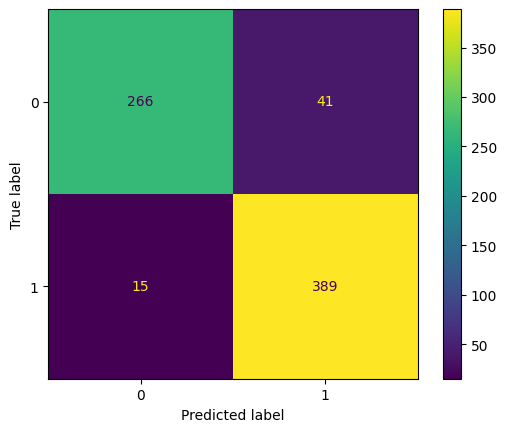

In [ ]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
display.plot()

## XGBoost

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 500]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.2, 0.3]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 12]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 5, 7]),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'gamma': trial.suggest_categorical('gamma', [0.5, 0.8, 1, 2])
    }

    model = XGBClassifier(**params, random_state=42)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-30 16:39:41,510] A new study created in memory with name: no-name-7cc4a00a-3d0d-4de5-8465-80d44bb9f96c
[I 2024-11-30 16:39:42,609] Trial 0 finished with value: 0.9166674917695982 and parameters: {'n_estimators': 500, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 1}. Best is trial 0 with value: 0.9166674917695982.
[I 2024-11-30 16:39:43,165] Trial 1 finished with value: 0.9145585286764524 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.8}. Best is trial 0 with value: 0.9166674917695982.
[I 2024-11-30 16:39:43,677] Trial 2 finished with value: 0.9191316616747939 and parameters: {'n_estimators': 200, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 1}. Best is trial 2 with value: 0.9191316616747939.
[I 2024-11-30 16:39:44,457] Trial 3 finished w

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
best_params = study.best_params
best_model = XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

Best hyperparameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 0.8}
Best cross-validation accuracy: 0.922649075472165
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       307
           1       0.92      0.97      0.94       404

    accuracy                           0.93       711
   macro avg       0.94      0.93      0.93       711
weighted avg       0.93      0.93      0.93       711



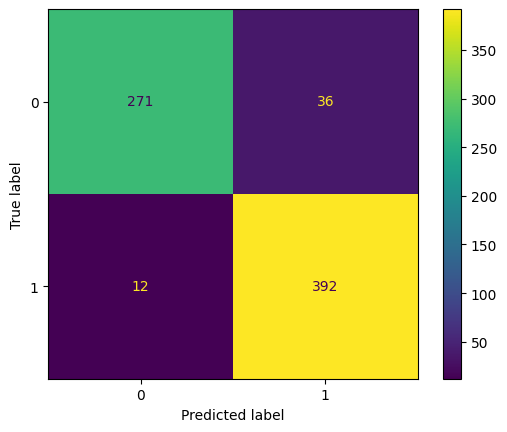

In [ ]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
display.plot()

## CatBoost

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 150, 200]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.2, 0.3]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 12]),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0, step=0.1)
    }

    model = CatBoostClassifier(**params, loss_function='Logloss', random_state=42)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', verbose=0).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-30 16:42:56,098] A new study created in memory with name: no-name-91876166-0443-414d-a2e6-312e65254495


0:	learn: 0.6332806	total: 48.3ms	remaining: 4.79s
1:	learn: 0.5868034	total: 49.9ms	remaining: 2.44s
2:	learn: 0.5445281	total: 51ms	remaining: 1.65s
3:	learn: 0.5097285	total: 52ms	remaining: 1.25s
4:	learn: 0.4782407	total: 53.3ms	remaining: 1.01s
5:	learn: 0.4525433	total: 54.3ms	remaining: 851ms
6:	learn: 0.4298478	total: 55.5ms	remaining: 737ms
7:	learn: 0.4114625	total: 56.7ms	remaining: 652ms
8:	learn: 0.3955583	total: 57.9ms	remaining: 586ms
9:	learn: 0.3805660	total: 59ms	remaining: 531ms
10:	learn: 0.3678766	total: 60ms	remaining: 486ms
11:	learn: 0.3554862	total: 61.1ms	remaining: 448ms
12:	learn: 0.3452576	total: 62.2ms	remaining: 416ms
13:	learn: 0.3371605	total: 63.2ms	remaining: 388ms
14:	learn: 0.3277285	total: 64.2ms	remaining: 364ms
15:	learn: 0.3196828	total: 65.3ms	remaining: 343ms
16:	learn: 0.3124766	total: 66.3ms	remaining: 324ms
17:	learn: 0.3065762	total: 67.4ms	remaining: 307ms
18:	learn: 0.3017472	total: 68.4ms	remaining: 292ms
19:	learn: 0.2953548	total: 69

[I 2024-11-30 16:42:56,969] Trial 0 finished with value: 0.9170220797544495 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0}. Best is trial 0 with value: 0.9170220797544495.


0:	learn: 0.6334473	total: 900us	remaining: 89.2ms
1:	learn: 0.5882710	total: 2.42ms	remaining: 118ms
2:	learn: 0.5464788	total: 3.54ms	remaining: 114ms
3:	learn: 0.5102803	total: 4.47ms	remaining: 107ms
4:	learn: 0.4789225	total: 5.58ms	remaining: 106ms
5:	learn: 0.4536132	total: 6.71ms	remaining: 105ms
6:	learn: 0.4307887	total: 7.77ms	remaining: 103ms
7:	learn: 0.4121903	total: 8.87ms	remaining: 102ms
8:	learn: 0.3970152	total: 9.95ms	remaining: 101ms
9:	learn: 0.3819279	total: 11ms	remaining: 98.8ms
10:	learn: 0.3686869	total: 12ms	remaining: 97.1ms
11:	learn: 0.3561639	total: 13.1ms	remaining: 95.9ms
12:	learn: 0.3463793	total: 14.2ms	remaining: 95ms
13:	learn: 0.3383624	total: 15.2ms	remaining: 93.4ms
14:	learn: 0.3290507	total: 16.2ms	remaining: 91.9ms
15:	learn: 0.3202649	total: 17.3ms	remaining: 90.8ms
16:	learn: 0.3126494	total: 18.6ms	remaining: 90.6ms
17:	learn: 0.3066733	total: 19.7ms	remaining: 89.9ms
18:	learn: 0.3011459	total: 21.4ms	remaining: 91.3ms
19:	learn: 0.29477

[I 2024-11-30 16:42:58,051] Trial 1 finished with value: 0.9138567786331345 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 1.0}. Best is trial 0 with value: 0.9170220797544495.


0:	learn: 0.6015761	total: 88.8ms	remaining: 13.2s
1:	learn: 0.5217990	total: 107ms	remaining: 7.9s
2:	learn: 0.4690895	total: 190ms	remaining: 9.3s
3:	learn: 0.4298055	total: 314ms	remaining: 11.5s
4:	learn: 0.3910653	total: 349ms	remaining: 10.1s
5:	learn: 0.3744742	total: 425ms	remaining: 10.2s
6:	learn: 0.3486224	total: 427ms	remaining: 8.71s
7:	learn: 0.3374049	total: 527ms	remaining: 9.35s
8:	learn: 0.3182312	total: 658ms	remaining: 10.3s
9:	learn: 0.3067231	total: 794ms	remaining: 11.1s
10:	learn: 0.2931816	total: 809ms	remaining: 10.2s
11:	learn: 0.2860278	total: 969ms	remaining: 11.1s
12:	learn: 0.2768138	total: 1.09s	remaining: 11.5s
13:	learn: 0.2685927	total: 1.24s	remaining: 12s
14:	learn: 0.2627845	total: 1.37s	remaining: 12.3s
15:	learn: 0.2575345	total: 1.46s	remaining: 12.3s
16:	learn: 0.2513032	total: 1.57s	remaining: 12.3s
17:	learn: 0.2455589	total: 1.66s	remaining: 12.1s
18:	learn: 0.2403164	total: 1.77s	remaining: 12.2s
19:	learn: 0.2333269	total: 1.88s	remaining:

[I 2024-11-30 16:43:39,887] Trial 2 finished with value: 0.9173748112577045 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 12, 'subsample': 0.9}. Best is trial 2 with value: 0.9173748112577045.


148:	learn: 0.0641374	total: 5.01s	remaining: 33.6ms
149:	learn: 0.0636817	total: 5.05s	remaining: 0us
0:	learn: 0.6424336	total: 34.3ms	remaining: 3.39s
1:	learn: 0.6010793	total: 65.8ms	remaining: 3.22s
2:	learn: 0.5575075	total: 71.5ms	remaining: 2.31s
3:	learn: 0.5189745	total: 72.6ms	remaining: 1.74s
4:	learn: 0.4962723	total: 110ms	remaining: 2.09s
5:	learn: 0.4688781	total: 148ms	remaining: 2.32s
6:	learn: 0.4549802	total: 186ms	remaining: 2.47s
7:	learn: 0.4343789	total: 223ms	remaining: 2.56s
8:	learn: 0.4187661	total: 255ms	remaining: 2.58s
9:	learn: 0.4029863	total: 287ms	remaining: 2.58s
10:	learn: 0.3869862	total: 323ms	remaining: 2.61s
11:	learn: 0.3721545	total: 355ms	remaining: 2.6s
12:	learn: 0.3619057	total: 387ms	remaining: 2.59s
13:	learn: 0.3514371	total: 420ms	remaining: 2.58s
14:	learn: 0.3426780	total: 459ms	remaining: 2.6s
15:	learn: 0.3352518	total: 505ms	remaining: 2.65s
16:	learn: 0.3280686	total: 543ms	remaining: 2.65s
17:	learn: 0.3205949	total: 579ms	rema

[I 2024-11-30 16:44:00,563] Trial 3 finished with value: 0.9149118790069061 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 12, 'subsample': 1.0}. Best is trial 2 with value: 0.9173748112577045.


95:	learn: 0.1576980	total: 4.13s	remaining: 172ms
96:	learn: 0.1568038	total: 4.17s	remaining: 129ms
97:	learn: 0.1557333	total: 4.2s	remaining: 85.7ms
98:	learn: 0.1546625	total: 4.23s	remaining: 42.7ms
99:	learn: 0.1537018	total: 4.26s	remaining: 0us
0:	learn: 0.5798188	total: 850us	remaining: 127ms
1:	learn: 0.5006274	total: 1.72ms	remaining: 127ms
2:	learn: 0.4464117	total: 2.54ms	remaining: 124ms
3:	learn: 0.4050333	total: 3.31ms	remaining: 121ms
4:	learn: 0.3757268	total: 4.08ms	remaining: 118ms
5:	learn: 0.3500545	total: 4.87ms	remaining: 117ms
6:	learn: 0.3331405	total: 5.48ms	remaining: 112ms
7:	learn: 0.3212303	total: 6.32ms	remaining: 112ms
8:	learn: 0.3087383	total: 7.15ms	remaining: 112ms
9:	learn: 0.3001537	total: 7.98ms	remaining: 112ms
10:	learn: 0.2913851	total: 8.81ms	remaining: 111ms
11:	learn: 0.2854651	total: 9.63ms	remaining: 111ms
12:	learn: 0.2800877	total: 10.5ms	remaining: 110ms
13:	learn: 0.2755190	total: 11.3ms	remaining: 109ms
14:	learn: 0.2708162	total: 1

[I 2024-11-30 16:44:01,501] Trial 4 finished with value: 0.9184292928042774 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8}. Best is trial 4 with value: 0.9184292928042774.


82:	learn: 0.2079377	total: 79.3ms	remaining: 64ms
83:	learn: 0.2075682	total: 80.1ms	remaining: 62.9ms
84:	learn: 0.2074754	total: 80.9ms	remaining: 61.9ms
85:	learn: 0.2071868	total: 82.4ms	remaining: 61.4ms
86:	learn: 0.2067152	total: 84.4ms	remaining: 61.1ms
87:	learn: 0.2062061	total: 85.5ms	remaining: 60.2ms
88:	learn: 0.2061592	total: 86.1ms	remaining: 59ms
89:	learn: 0.2059231	total: 86.7ms	remaining: 57.8ms
90:	learn: 0.2055456	total: 87.2ms	remaining: 56.6ms
91:	learn: 0.2055042	total: 87.8ms	remaining: 55.3ms
92:	learn: 0.2054467	total: 88.3ms	remaining: 54.1ms
93:	learn: 0.2054077	total: 89.1ms	remaining: 53.1ms
94:	learn: 0.2053572	total: 89.9ms	remaining: 52.1ms
95:	learn: 0.2046055	total: 90.8ms	remaining: 51.1ms
96:	learn: 0.2037761	total: 91.6ms	remaining: 50ms
97:	learn: 0.2037398	total: 92.4ms	remaining: 49ms
98:	learn: 0.2035946	total: 93.2ms	remaining: 48ms
99:	learn: 0.2032270	total: 94ms	remaining: 47ms
100:	learn: 0.2023823	total: 94.8ms	remaining: 46ms
101:	lea

[I 2024-11-30 16:44:02,226] Trial 5 finished with value: 0.9170208421000521 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.9}. Best is trial 4 with value: 0.9184292928042774.


0:	learn: 0.4351530	total: 33.5ms	remaining: 6.67s
1:	learn: 0.3297024	total: 67.4ms	remaining: 6.67s
2:	learn: 0.2709654	total: 113ms	remaining: 7.43s
3:	learn: 0.2340910	total: 151ms	remaining: 7.38s
4:	learn: 0.2060804	total: 185ms	remaining: 7.21s
5:	learn: 0.1908685	total: 224ms	remaining: 7.24s
6:	learn: 0.1746692	total: 261ms	remaining: 7.2s
7:	learn: 0.1599250	total: 295ms	remaining: 7.08s
8:	learn: 0.1499651	total: 327ms	remaining: 6.95s
9:	learn: 0.1384706	total: 368ms	remaining: 6.99s
10:	learn: 0.1328303	total: 405ms	remaining: 6.96s
11:	learn: 0.1216992	total: 439ms	remaining: 6.88s
12:	learn: 0.1123319	total: 480ms	remaining: 6.91s
13:	learn: 0.1021420	total: 514ms	remaining: 6.83s
14:	learn: 0.0930809	total: 549ms	remaining: 6.77s
15:	learn: 0.0866144	total: 583ms	remaining: 6.71s
16:	learn: 0.0826134	total: 616ms	remaining: 6.63s
17:	learn: 0.0782887	total: 648ms	remaining: 6.55s
18:	learn: 0.0758432	total: 688ms	remaining: 6.56s
19:	learn: 0.0697682	total: 721ms	remain

[I 2024-11-30 16:44:42,634] Trial 6 finished with value: 0.9135052847842768 and parameters: {'n_estimators': 200, 'learning_rate': 0.3, 'max_depth': 12, 'subsample': 1.0}. Best is trial 4 with value: 0.9184292928042774.


0:	learn: 0.5829738	total: 1.01ms	remaining: 100ms
1:	learn: 0.5046465	total: 2.05ms	remaining: 100ms
2:	learn: 0.4548658	total: 3.07ms	remaining: 99.3ms
3:	learn: 0.4101867	total: 4.05ms	remaining: 97.3ms
4:	learn: 0.3767967	total: 5.05ms	remaining: 96ms
5:	learn: 0.3508596	total: 6.39ms	remaining: 100ms
6:	learn: 0.3313495	total: 7.88ms	remaining: 105ms
7:	learn: 0.3150134	total: 9.27ms	remaining: 107ms
8:	learn: 0.3032266	total: 11ms	remaining: 111ms
9:	learn: 0.2921419	total: 12.4ms	remaining: 111ms
10:	learn: 0.2828983	total: 13.7ms	remaining: 111ms
11:	learn: 0.2758874	total: 15.3ms	remaining: 112ms
12:	learn: 0.2706699	total: 16.6ms	remaining: 111ms
13:	learn: 0.2654460	total: 17.7ms	remaining: 109ms
14:	learn: 0.2611541	total: 18.8ms	remaining: 106ms
15:	learn: 0.2556497	total: 20.1ms	remaining: 105ms
16:	learn: 0.2520450	total: 21.3ms	remaining: 104ms
17:	learn: 0.2489085	total: 22.5ms	remaining: 102ms
18:	learn: 0.2459500	total: 23.8ms	remaining: 101ms
19:	learn: 0.2435575	to

[I 2024-11-30 16:44:43,545] Trial 7 finished with value: 0.9184286739770785 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.8}. Best is trial 4 with value: 0.9184292928042774.


77:	learn: 0.1851918	total: 92ms	remaining: 25.9ms
78:	learn: 0.1850686	total: 93.2ms	remaining: 24.8ms
79:	learn: 0.1839951	total: 95.5ms	remaining: 23.9ms
80:	learn: 0.1839569	total: 98.5ms	remaining: 23.1ms
81:	learn: 0.1831934	total: 101ms	remaining: 22.1ms
82:	learn: 0.1830292	total: 103ms	remaining: 21.1ms
83:	learn: 0.1828766	total: 104ms	remaining: 19.9ms
84:	learn: 0.1821257	total: 106ms	remaining: 18.6ms
85:	learn: 0.1819986	total: 107ms	remaining: 17.4ms
86:	learn: 0.1811726	total: 108ms	remaining: 16.1ms
87:	learn: 0.1810121	total: 109ms	remaining: 14.9ms
88:	learn: 0.1804600	total: 110ms	remaining: 13.6ms
89:	learn: 0.1803292	total: 111ms	remaining: 12.4ms
90:	learn: 0.1802561	total: 112ms	remaining: 11.1ms
91:	learn: 0.1801360	total: 114ms	remaining: 9.88ms
92:	learn: 0.1793472	total: 115ms	remaining: 8.64ms
93:	learn: 0.1793182	total: 116ms	remaining: 7.4ms
94:	learn: 0.1789355	total: 117ms	remaining: 6.16ms
95:	learn: 0.1785819	total: 118ms	remaining: 4.92ms
96:	learn: 

[I 2024-11-30 16:45:24,161] Trial 8 finished with value: 0.9124532785464986 and parameters: {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 12, 'subsample': 1.0}. Best is trial 4 with value: 0.9184292928042774.


196:	learn: 0.0058585	total: 8.48s	remaining: 129ms
197:	learn: 0.0058585	total: 8.51s	remaining: 86ms
198:	learn: 0.0058585	total: 8.55s	remaining: 43ms
199:	learn: 0.0058585	total: 8.58s	remaining: 0us
0:	learn: 0.6672595	total: 39.5ms	remaining: 3.91s
1:	learn: 0.6444387	total: 71.4ms	remaining: 3.5s
2:	learn: 0.6187199	total: 76.6ms	remaining: 2.48s
3:	learn: 0.5940591	total: 77.7ms	remaining: 1.86s
4:	learn: 0.5784800	total: 110ms	remaining: 2.09s
5:	learn: 0.5591406	total: 141ms	remaining: 2.21s
6:	learn: 0.5445095	total: 173ms	remaining: 2.3s
7:	learn: 0.5277906	total: 208ms	remaining: 2.39s
8:	learn: 0.5153545	total: 240ms	remaining: 2.43s
9:	learn: 0.5020962	total: 277ms	remaining: 2.5s
10:	learn: 0.4883266	total: 308ms	remaining: 2.49s
11:	learn: 0.4746179	total: 339ms	remaining: 2.48s
12:	learn: 0.4624005	total: 384ms	remaining: 2.57s
13:	learn: 0.4511180	total: 401ms	remaining: 2.46s
14:	learn: 0.4429391	total: 434ms	remaining: 2.46s
15:	learn: 0.4344201	total: 475ms	remain

[I 2024-11-30 16:45:42,390] Trial 9 finished with value: 0.9131531721082204 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 12, 'subsample': 1.0}. Best is trial 4 with value: 0.9184292928042774.


99:	learn: 0.2180482	total: 3.27s	remaining: 0us
0:	learn: 0.5322802	total: 638us	remaining: 95.2ms
1:	learn: 0.4391472	total: 1.61ms	remaining: 119ms
2:	learn: 0.3829446	total: 2.58ms	remaining: 127ms
3:	learn: 0.3458276	total: 3.34ms	remaining: 122ms
4:	learn: 0.3234627	total: 4.19ms	remaining: 121ms
5:	learn: 0.3040951	total: 5.02ms	remaining: 120ms
6:	learn: 0.2912772	total: 5.79ms	remaining: 118ms
7:	learn: 0.2814117	total: 6.58ms	remaining: 117ms
8:	learn: 0.2723154	total: 7.39ms	remaining: 116ms
9:	learn: 0.2663684	total: 8.21ms	remaining: 115ms
10:	learn: 0.2620080	total: 9.03ms	remaining: 114ms
11:	learn: 0.2593807	total: 9.86ms	remaining: 113ms
12:	learn: 0.2532995	total: 10.7ms	remaining: 113ms
13:	learn: 0.2507596	total: 11.5ms	remaining: 112ms
14:	learn: 0.2475584	total: 12.4ms	remaining: 111ms
15:	learn: 0.2461410	total: 13.2ms	remaining: 111ms
16:	learn: 0.2443106	total: 14ms	remaining: 110ms
17:	learn: 0.2410573	total: 14.9ms	remaining: 109ms
18:	learn: 0.2396193	total:

[I 2024-11-30 16:45:43,357] Trial 10 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


25:	learn: 0.2257013	total: 27.6ms	remaining: 132ms
26:	learn: 0.2253643	total: 28.5ms	remaining: 130ms
27:	learn: 0.2243861	total: 29.3ms	remaining: 128ms
28:	learn: 0.2230198	total: 37ms	remaining: 154ms
29:	learn: 0.2214559	total: 37.7ms	remaining: 151ms
30:	learn: 0.2202342	total: 38.4ms	remaining: 147ms
31:	learn: 0.2196324	total: 39.1ms	remaining: 144ms
32:	learn: 0.2190079	total: 39.7ms	remaining: 141ms
33:	learn: 0.2186413	total: 40.4ms	remaining: 138ms
34:	learn: 0.2177537	total: 41.2ms	remaining: 135ms
35:	learn: 0.2172491	total: 43.5ms	remaining: 138ms
36:	learn: 0.2167440	total: 44.3ms	remaining: 135ms
37:	learn: 0.2162392	total: 45.6ms	remaining: 134ms
38:	learn: 0.2161874	total: 46.4ms	remaining: 132ms
39:	learn: 0.2159554	total: 48.3ms	remaining: 133ms
40:	learn: 0.2157591	total: 49.1ms	remaining: 130ms
41:	learn: 0.2154513	total: 49.8ms	remaining: 128ms
42:	learn: 0.2149279	total: 51.3ms	remaining: 128ms
43:	learn: 0.2146947	total: 51.9ms	remaining: 125ms
44:	learn: 0.2

[I 2024-11-30 16:45:44,319] Trial 11 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


104:	learn: 0.1860922	total: 86.9ms	remaining: 37.2ms
105:	learn: 0.1860495	total: 87.8ms	remaining: 36.4ms
106:	learn: 0.1857310	total: 89.6ms	remaining: 36ms
107:	learn: 0.1853057	total: 90.4ms	remaining: 35.2ms
108:	learn: 0.1846268	total: 97.8ms	remaining: 36.8ms
109:	learn: 0.1843593	total: 100ms	remaining: 36.4ms
110:	learn: 0.1841749	total: 101ms	remaining: 35.5ms
111:	learn: 0.1834533	total: 103ms	remaining: 35.1ms
112:	learn: 0.1832169	total: 105ms	remaining: 34.4ms
113:	learn: 0.1831759	total: 106ms	remaining: 33.4ms
114:	learn: 0.1831026	total: 109ms	remaining: 33ms
115:	learn: 0.1830679	total: 109ms	remaining: 32ms
116:	learn: 0.1830363	total: 111ms	remaining: 31.2ms
117:	learn: 0.1830031	total: 111ms	remaining: 30.2ms
118:	learn: 0.1828883	total: 112ms	remaining: 29.2ms
119:	learn: 0.1828234	total: 114ms	remaining: 28.4ms
120:	learn: 0.1823443	total: 115ms	remaining: 27.6ms
121:	learn: 0.1822861	total: 117ms	remaining: 26.8ms
122:	learn: 0.1821139	total: 117ms	remaining: 2

[I 2024-11-30 16:45:45,559] Trial 12 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


120:	learn: 0.1823443	total: 186ms	remaining: 44.5ms
121:	learn: 0.1822861	total: 189ms	remaining: 43.5ms
122:	learn: 0.1821139	total: 191ms	remaining: 41.9ms
123:	learn: 0.1817693	total: 192ms	remaining: 40.3ms
124:	learn: 0.1816902	total: 196ms	remaining: 39.2ms
125:	learn: 0.1814179	total: 197ms	remaining: 37.6ms
126:	learn: 0.1813994	total: 201ms	remaining: 36.4ms
127:	learn: 0.1813450	total: 202ms	remaining: 34.8ms
128:	learn: 0.1812905	total: 205ms	remaining: 33.4ms
129:	learn: 0.1808443	total: 207ms	remaining: 31.8ms
130:	learn: 0.1803880	total: 210ms	remaining: 30.4ms
131:	learn: 0.1800937	total: 211ms	remaining: 28.8ms
132:	learn: 0.1794005	total: 213ms	remaining: 27.3ms
133:	learn: 0.1788684	total: 215ms	remaining: 25.7ms
134:	learn: 0.1784390	total: 216ms	remaining: 24ms
135:	learn: 0.1779534	total: 218ms	remaining: 22.4ms
136:	learn: 0.1778673	total: 219ms	remaining: 20.8ms
137:	learn: 0.1773975	total: 221ms	remaining: 19.2ms
138:	learn: 0.1772295	total: 222ms	remaining: 17

[I 2024-11-30 16:45:47,265] Trial 13 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


88:	learn: 0.1914443	total: 149ms	remaining: 102ms
89:	learn: 0.1913040	total: 150ms	remaining: 100ms
90:	learn: 0.1908976	total: 152ms	remaining: 98.6ms
91:	learn: 0.1907813	total: 153ms	remaining: 96.7ms
92:	learn: 0.1902931	total: 155ms	remaining: 94.9ms
93:	learn: 0.1895967	total: 156ms	remaining: 93.2ms
94:	learn: 0.1894352	total: 159ms	remaining: 92.1ms
95:	learn: 0.1888874	total: 161ms	remaining: 90.4ms
96:	learn: 0.1886504	total: 162ms	remaining: 88.6ms
97:	learn: 0.1884365	total: 164ms	remaining: 87.1ms
98:	learn: 0.1882735	total: 166ms	remaining: 85.7ms
99:	learn: 0.1878447	total: 168ms	remaining: 83.8ms
100:	learn: 0.1877483	total: 169ms	remaining: 82.1ms
101:	learn: 0.1874009	total: 171ms	remaining: 80.3ms
102:	learn: 0.1872137	total: 171ms	remaining: 78.1ms
103:	learn: 0.1865163	total: 172ms	remaining: 76ms
104:	learn: 0.1860922	total: 173ms	remaining: 74.1ms
105:	learn: 0.1860495	total: 174ms	remaining: 72.1ms
106:	learn: 0.1857310	total: 174ms	remaining: 70.1ms
107:	lear

[I 2024-11-30 16:45:48,647] Trial 14 finished with value: 0.9170214609272506 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.9}. Best is trial 10 with value: 0.9219460877744499.


82:	learn: 0.2008592	total: 79.2ms	remaining: 64ms
83:	learn: 0.2008130	total: 80ms	remaining: 62.9ms
84:	learn: 0.2002758	total: 80.8ms	remaining: 61.8ms
85:	learn: 0.2000170	total: 81.5ms	remaining: 60.7ms
86:	learn: 0.1995425	total: 84.2ms	remaining: 61ms
87:	learn: 0.1992147	total: 85.2ms	remaining: 60.1ms
88:	learn: 0.1990692	total: 86.3ms	remaining: 59.1ms
89:	learn: 0.1987544	total: 87.1ms	remaining: 58.1ms
90:	learn: 0.1984141	total: 87.9ms	remaining: 57ms
91:	learn: 0.1969083	total: 88.8ms	remaining: 56ms
92:	learn: 0.1967998	total: 89.6ms	remaining: 54.9ms
93:	learn: 0.1966190	total: 90.2ms	remaining: 53.7ms
94:	learn: 0.1965694	total: 90.9ms	remaining: 52.6ms
95:	learn: 0.1958199	total: 91.6ms	remaining: 51.5ms
96:	learn: 0.1957468	total: 92.3ms	remaining: 50.4ms
97:	learn: 0.1952802	total: 92.8ms	remaining: 49.3ms
98:	learn: 0.1943906	total: 93.7ms	remaining: 48.3ms
99:	learn: 0.1940833	total: 94.5ms	remaining: 47.3ms
100:	learn: 0.1931884	total: 95.3ms	remaining: 46.3ms
10

[I 2024-11-30 16:45:49,648] Trial 15 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


131:	learn: 0.1800937	total: 123ms	remaining: 16.8ms
132:	learn: 0.1794005	total: 124ms	remaining: 15.9ms
133:	learn: 0.1788684	total: 126ms	remaining: 15ms
134:	learn: 0.1784390	total: 127ms	remaining: 14.1ms
135:	learn: 0.1779534	total: 129ms	remaining: 13.2ms
136:	learn: 0.1778673	total: 132ms	remaining: 12.5ms
137:	learn: 0.1773975	total: 133ms	remaining: 11.5ms
138:	learn: 0.1772295	total: 133ms	remaining: 10.6ms
139:	learn: 0.1766864	total: 134ms	remaining: 9.59ms
140:	learn: 0.1765511	total: 135ms	remaining: 8.62ms
141:	learn: 0.1756649	total: 136ms	remaining: 7.65ms
142:	learn: 0.1755270	total: 139ms	remaining: 6.82ms
143:	learn: 0.1752142	total: 140ms	remaining: 5.83ms
144:	learn: 0.1748656	total: 141ms	remaining: 4.86ms
145:	learn: 0.1747219	total: 141ms	remaining: 3.88ms
146:	learn: 0.1745613	total: 142ms	remaining: 2.9ms
147:	learn: 0.1741443	total: 143ms	remaining: 1.93ms
148:	learn: 0.1740792	total: 144ms	remaining: 963us
149:	learn: 0.1739126	total: 144ms	remaining: 0us


[I 2024-11-30 16:45:51,440] Trial 16 finished with value: 0.9120962152528529 and parameters: {'n_estimators': 200, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


129:	learn: 0.1234934	total: 188ms	remaining: 101ms
130:	learn: 0.1231751	total: 190ms	remaining: 99.9ms
131:	learn: 0.1219417	total: 192ms	remaining: 99.1ms
132:	learn: 0.1210468	total: 195ms	remaining: 98.3ms
133:	learn: 0.1205612	total: 199ms	remaining: 97.8ms
134:	learn: 0.1197883	total: 200ms	remaining: 96.3ms
135:	learn: 0.1193093	total: 201ms	remaining: 94.8ms
136:	learn: 0.1191099	total: 203ms	remaining: 93.3ms
137:	learn: 0.1185409	total: 205ms	remaining: 91.9ms
138:	learn: 0.1180364	total: 206ms	remaining: 90.4ms
139:	learn: 0.1173394	total: 207ms	remaining: 88.8ms
140:	learn: 0.1172848	total: 209ms	remaining: 87.3ms
141:	learn: 0.1169821	total: 210ms	remaining: 85.7ms
142:	learn: 0.1161527	total: 211ms	remaining: 84.2ms
143:	learn: 0.1159547	total: 212ms	remaining: 82.6ms
144:	learn: 0.1154564	total: 214ms	remaining: 81.1ms
145:	learn: 0.1149214	total: 215ms	remaining: 79.5ms
146:	learn: 0.1145674	total: 216ms	remaining: 78ms
147:	learn: 0.1141007	total: 218ms	remaining: 76.

[I 2024-11-30 16:45:52,749] Trial 17 finished with value: 0.9187814054803336 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 5, 'subsample': 0.9}. Best is trial 10 with value: 0.9219460877744499.


58:	learn: 0.1809285	total: 76.2ms	remaining: 118ms
59:	learn: 0.1808075	total: 77.5ms	remaining: 116ms
60:	learn: 0.1807253	total: 78.9ms	remaining: 115ms
61:	learn: 0.1799038	total: 80.3ms	remaining: 114ms
62:	learn: 0.1797148	total: 85.9ms	remaining: 119ms
63:	learn: 0.1793460	total: 87.3ms	remaining: 117ms
64:	learn: 0.1786541	total: 88.7ms	remaining: 116ms
65:	learn: 0.1782189	total: 90.1ms	remaining: 115ms
66:	learn: 0.1781521	total: 91.4ms	remaining: 113ms
67:	learn: 0.1764522	total: 92.8ms	remaining: 112ms
68:	learn: 0.1758447	total: 94.1ms	remaining: 110ms
69:	learn: 0.1755757	total: 96.1ms	remaining: 110ms
70:	learn: 0.1750642	total: 97.3ms	remaining: 108ms
71:	learn: 0.1746916	total: 98.5ms	remaining: 107ms
72:	learn: 0.1741297	total: 99.6ms	remaining: 105ms
73:	learn: 0.1726086	total: 101ms	remaining: 104ms
74:	learn: 0.1722727	total: 102ms	remaining: 102ms
75:	learn: 0.1717710	total: 103ms	remaining: 100ms
76:	learn: 0.1708941	total: 109ms	remaining: 103ms
77:	learn: 0.169

[I 2024-11-30 16:45:53,765] Trial 18 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


77:	learn: 0.1951780	total: 76.8ms	remaining: 70.9ms
78:	learn: 0.1951077	total: 78.3ms	remaining: 70.3ms
79:	learn: 0.1947453	total: 80.5ms	remaining: 70.4ms
80:	learn: 0.1942822	total: 82ms	remaining: 69.8ms
81:	learn: 0.1935872	total: 90.2ms	remaining: 74.8ms
82:	learn: 0.1934319	total: 92.8ms	remaining: 74.9ms
83:	learn: 0.1933731	total: 97.5ms	remaining: 76.6ms
84:	learn: 0.1930168	total: 100ms	remaining: 76.5ms
85:	learn: 0.1929623	total: 102ms	remaining: 76.1ms
86:	learn: 0.1926751	total: 103ms	remaining: 74.9ms
87:	learn: 0.1919780	total: 104ms	remaining: 73.6ms
88:	learn: 0.1914443	total: 105ms	remaining: 72.2ms
89:	learn: 0.1913040	total: 106ms	remaining: 70.8ms
90:	learn: 0.1908976	total: 107ms	remaining: 69.4ms
91:	learn: 0.1907813	total: 108ms	remaining: 68ms
92:	learn: 0.1902931	total: 109ms	remaining: 66.6ms
93:	learn: 0.1895967	total: 109ms	remaining: 65.2ms
94:	learn: 0.1894352	total: 110ms	remaining: 63.8ms
95:	learn: 0.1888874	total: 111ms	remaining: 62.5ms
96:	learn

[I 2024-11-30 16:45:54,777] Trial 19 finished with value: 0.9138567786331345 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.9}. Best is trial 10 with value: 0.9219460877744499.


100:	learn: 0.2453824	total: 96.1ms	remaining: 46.6ms
101:	learn: 0.2452796	total: 98ms	remaining: 46.1ms
102:	learn: 0.2447769	total: 99.4ms	remaining: 45.4ms
103:	learn: 0.2443805	total: 101ms	remaining: 44.7ms
104:	learn: 0.2435476	total: 103ms	remaining: 43.9ms
105:	learn: 0.2430847	total: 104ms	remaining: 43.2ms
106:	learn: 0.2429143	total: 106ms	remaining: 42.4ms
107:	learn: 0.2425955	total: 107ms	remaining: 41.6ms
108:	learn: 0.2424576	total: 109ms	remaining: 40.8ms
109:	learn: 0.2419393	total: 110ms	remaining: 40ms
110:	learn: 0.2412680	total: 111ms	remaining: 39.1ms
111:	learn: 0.2408822	total: 113ms	remaining: 38.3ms
112:	learn: 0.2405865	total: 114ms	remaining: 37.5ms
113:	learn: 0.2401206	total: 116ms	remaining: 36.6ms
114:	learn: 0.2399112	total: 117ms	remaining: 35.7ms
115:	learn: 0.2397626	total: 118ms	remaining: 34.6ms
116:	learn: 0.2393980	total: 119ms	remaining: 33.4ms
117:	learn: 0.2391485	total: 119ms	remaining: 32.4ms
118:	learn: 0.2388533	total: 120ms	remaining: 3

[I 2024-11-30 16:45:57,012] Trial 20 finished with value: 0.9096407089284388 and parameters: {'n_estimators': 200, 'learning_rate': 0.3, 'max_depth': 5, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


0:	learn: 0.5322802	total: 655us	remaining: 97.6ms
1:	learn: 0.4391472	total: 1.27ms	remaining: 94.3ms
2:	learn: 0.3829446	total: 1.85ms	remaining: 90.8ms
3:	learn: 0.3458276	total: 2.57ms	remaining: 93.7ms
4:	learn: 0.3234627	total: 3.61ms	remaining: 105ms
5:	learn: 0.3040951	total: 4.6ms	remaining: 110ms
6:	learn: 0.2912772	total: 5.37ms	remaining: 110ms
7:	learn: 0.2814117	total: 6.17ms	remaining: 110ms
8:	learn: 0.2723154	total: 6.88ms	remaining: 108ms
9:	learn: 0.2663684	total: 7.79ms	remaining: 109ms
10:	learn: 0.2620080	total: 8.39ms	remaining: 106ms
11:	learn: 0.2593807	total: 9.15ms	remaining: 105ms
12:	learn: 0.2532995	total: 10ms	remaining: 105ms
13:	learn: 0.2507596	total: 10.8ms	remaining: 105ms
14:	learn: 0.2475584	total: 11.7ms	remaining: 105ms
15:	learn: 0.2461410	total: 12.3ms	remaining: 103ms
16:	learn: 0.2443106	total: 13.1ms	remaining: 103ms
17:	learn: 0.2410573	total: 13.9ms	remaining: 102ms
18:	learn: 0.2396193	total: 14.6ms	remaining: 101ms
19:	learn: 0.2376292	t

[I 2024-11-30 16:45:58,047] Trial 21 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


23:	learn: 0.2283809	total: 22.9ms	remaining: 120ms
24:	learn: 0.2263710	total: 24.7ms	remaining: 124ms
25:	learn: 0.2257013	total: 26.1ms	remaining: 125ms
26:	learn: 0.2253643	total: 27.7ms	remaining: 126ms
27:	learn: 0.2243861	total: 28.9ms	remaining: 126ms
28:	learn: 0.2230198	total: 30.8ms	remaining: 128ms
29:	learn: 0.2214559	total: 33.9ms	remaining: 135ms
30:	learn: 0.2202342	total: 34.7ms	remaining: 133ms
31:	learn: 0.2196324	total: 35.6ms	remaining: 131ms
32:	learn: 0.2190079	total: 36.2ms	remaining: 129ms
33:	learn: 0.2186413	total: 37ms	remaining: 126ms
34:	learn: 0.2177537	total: 37.7ms	remaining: 124ms
35:	learn: 0.2172491	total: 38.4ms	remaining: 122ms
36:	learn: 0.2167440	total: 39.2ms	remaining: 120ms
37:	learn: 0.2162392	total: 40ms	remaining: 118ms
38:	learn: 0.2161874	total: 40.8ms	remaining: 116ms
39:	learn: 0.2159554	total: 41.6ms	remaining: 114ms
40:	learn: 0.2157591	total: 42.4ms	remaining: 113ms
41:	learn: 0.2154513	total: 42.9ms	remaining: 110ms
42:	learn: 0.214

[I 2024-11-30 16:45:59,459] Trial 22 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


123:	learn: 0.1817693	total: 143ms	remaining: 30ms
124:	learn: 0.1816902	total: 145ms	remaining: 29ms
125:	learn: 0.1814179	total: 146ms	remaining: 27.9ms
126:	learn: 0.1813994	total: 148ms	remaining: 26.8ms
127:	learn: 0.1813450	total: 149ms	remaining: 25.6ms
128:	learn: 0.1812905	total: 151ms	remaining: 24.6ms
129:	learn: 0.1808443	total: 153ms	remaining: 23.5ms
130:	learn: 0.1803880	total: 154ms	remaining: 22.4ms
131:	learn: 0.1800937	total: 156ms	remaining: 21.2ms
132:	learn: 0.1794005	total: 160ms	remaining: 20.5ms
133:	learn: 0.1788684	total: 162ms	remaining: 19.3ms
134:	learn: 0.1784390	total: 164ms	remaining: 18.2ms
135:	learn: 0.1779534	total: 165ms	remaining: 17ms
136:	learn: 0.1778673	total: 167ms	remaining: 15.8ms
137:	learn: 0.1773975	total: 168ms	remaining: 14.6ms
138:	learn: 0.1772295	total: 170ms	remaining: 13.5ms
139:	learn: 0.1766864	total: 172ms	remaining: 12.3ms
140:	learn: 0.1765511	total: 172ms	remaining: 11ms
141:	learn: 0.1756649	total: 173ms	remaining: 9.76ms
1

[I 2024-11-30 16:46:01,148] Trial 23 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


107:	learn: 0.1853057	total: 173ms	remaining: 67.2ms
108:	learn: 0.1846268	total: 176ms	remaining: 66.2ms
109:	learn: 0.1843593	total: 179ms	remaining: 65.1ms
110:	learn: 0.1841749	total: 182ms	remaining: 64ms
111:	learn: 0.1834533	total: 186ms	remaining: 63.3ms
112:	learn: 0.1832169	total: 188ms	remaining: 61.7ms
113:	learn: 0.1831759	total: 192ms	remaining: 60.5ms
114:	learn: 0.1831026	total: 195ms	remaining: 59.4ms
115:	learn: 0.1830679	total: 197ms	remaining: 57.8ms
116:	learn: 0.1830363	total: 199ms	remaining: 56.1ms
117:	learn: 0.1830031	total: 200ms	remaining: 54.2ms
118:	learn: 0.1828883	total: 201ms	remaining: 52.3ms
119:	learn: 0.1828234	total: 201ms	remaining: 50.4ms
120:	learn: 0.1823443	total: 202ms	remaining: 48.5ms
121:	learn: 0.1822861	total: 203ms	remaining: 46.6ms
122:	learn: 0.1821139	total: 204ms	remaining: 44.7ms
123:	learn: 0.1817693	total: 206ms	remaining: 43.1ms
124:	learn: 0.1816902	total: 206ms	remaining: 41.3ms
125:	learn: 0.1814179	total: 207ms	remaining: 39

[I 2024-11-30 16:46:02,564] Trial 24 finished with value: 0.9170214609272506 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.9}. Best is trial 10 with value: 0.9219460877744499.


115:	learn: 0.1893100	total: 94.8ms	remaining: 27.8ms
116:	learn: 0.1890419	total: 96.7ms	remaining: 27.3ms
117:	learn: 0.1889975	total: 98.3ms	remaining: 26.7ms
118:	learn: 0.1889547	total: 99.7ms	remaining: 26ms
119:	learn: 0.1889133	total: 102ms	remaining: 25.4ms
120:	learn: 0.1888760	total: 105ms	remaining: 25.2ms
121:	learn: 0.1888363	total: 106ms	remaining: 24.3ms
122:	learn: 0.1888012	total: 107ms	remaining: 23.4ms
123:	learn: 0.1883701	total: 107ms	remaining: 22.5ms
124:	learn: 0.1882885	total: 110ms	remaining: 21.9ms
125:	learn: 0.1882540	total: 114ms	remaining: 21.7ms
126:	learn: 0.1876448	total: 116ms	remaining: 21ms
127:	learn: 0.1870549	total: 118ms	remaining: 20.2ms
128:	learn: 0.1867493	total: 118ms	remaining: 19.2ms
129:	learn: 0.1858859	total: 119ms	remaining: 18.3ms
130:	learn: 0.1845889	total: 120ms	remaining: 17.4ms
131:	learn: 0.1841985	total: 121ms	remaining: 16.5ms
132:	learn: 0.1840166	total: 121ms	remaining: 15.5ms
133:	learn: 0.1837970	total: 122ms	remaining: 

[I 2024-11-30 16:46:03,536] Trial 25 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


0:	learn: 0.5322802	total: 911us	remaining: 136ms
1:	learn: 0.4391472	total: 1.57ms	remaining: 116ms
2:	learn: 0.3829446	total: 2.13ms	remaining: 105ms
3:	learn: 0.3458276	total: 3.2ms	remaining: 117ms
4:	learn: 0.3234627	total: 3.82ms	remaining: 111ms
5:	learn: 0.3040951	total: 4.71ms	remaining: 113ms
6:	learn: 0.2912772	total: 5.51ms	remaining: 113ms
7:	learn: 0.2814117	total: 6.19ms	remaining: 110ms
8:	learn: 0.2723154	total: 6.99ms	remaining: 109ms
9:	learn: 0.2663684	total: 7.63ms	remaining: 107ms
10:	learn: 0.2620080	total: 8.51ms	remaining: 108ms
11:	learn: 0.2593807	total: 9.29ms	remaining: 107ms
12:	learn: 0.2532995	total: 10.4ms	remaining: 109ms
13:	learn: 0.2507596	total: 11.1ms	remaining: 108ms
14:	learn: 0.2475584	total: 11.9ms	remaining: 107ms
15:	learn: 0.2461410	total: 12.7ms	remaining: 106ms
16:	learn: 0.2443106	total: 13.6ms	remaining: 106ms
17:	learn: 0.2410573	total: 14.5ms	remaining: 107ms
18:	learn: 0.2396193	total: 15.2ms	remaining: 105ms
19:	learn: 0.2376292	tot

[I 2024-11-30 16:46:04,495] Trial 26 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


93:	learn: 0.1895967	total: 79.2ms	remaining: 47.2ms
94:	learn: 0.1894352	total: 80.1ms	remaining: 46.4ms
95:	learn: 0.1888874	total: 82ms	remaining: 46.1ms
96:	learn: 0.1886504	total: 82.8ms	remaining: 45.3ms
97:	learn: 0.1884365	total: 83.6ms	remaining: 44.4ms
98:	learn: 0.1882735	total: 84.4ms	remaining: 43.5ms
99:	learn: 0.1878447	total: 86.2ms	remaining: 43.1ms
100:	learn: 0.1877483	total: 87.7ms	remaining: 42.6ms
101:	learn: 0.1874009	total: 89.1ms	remaining: 41.9ms
102:	learn: 0.1872137	total: 90.5ms	remaining: 41.3ms
103:	learn: 0.1865163	total: 92ms	remaining: 40.7ms
104:	learn: 0.1860922	total: 93.6ms	remaining: 40.1ms
105:	learn: 0.1860495	total: 94.9ms	remaining: 39.4ms
106:	learn: 0.1857310	total: 96.3ms	remaining: 38.7ms
107:	learn: 0.1853057	total: 97.7ms	remaining: 38ms
108:	learn: 0.1846268	total: 99.2ms	remaining: 37.3ms
109:	learn: 0.1843593	total: 101ms	remaining: 36.7ms
110:	learn: 0.1841749	total: 102ms	remaining: 35.8ms
111:	learn: 0.1834533	total: 103ms	remainin

[I 2024-11-30 16:46:05,478] Trial 27 finished with value: 0.9138567786331345 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.9}. Best is trial 10 with value: 0.9219460877744499.


140:	learn: 0.2332873	total: 125ms	remaining: 7.96ms
141:	learn: 0.2327553	total: 126ms	remaining: 7.11ms
142:	learn: 0.2325634	total: 127ms	remaining: 6.21ms
143:	learn: 0.2322049	total: 129ms	remaining: 5.39ms
144:	learn: 0.2317191	total: 134ms	remaining: 4.63ms
145:	learn: 0.2315404	total: 135ms	remaining: 3.7ms
146:	learn: 0.2313967	total: 136ms	remaining: 2.77ms
147:	learn: 0.2311645	total: 137ms	remaining: 1.85ms
148:	learn: 0.2310254	total: 137ms	remaining: 921us
149:	learn: 0.2307180	total: 138ms	remaining: 0us
0:	learn: 0.5981100	total: 1.23ms	remaining: 245ms
1:	learn: 0.5344564	total: 2.69ms	remaining: 267ms
2:	learn: 0.4773710	total: 4.03ms	remaining: 265ms
3:	learn: 0.4289784	total: 5.34ms	remaining: 262ms
4:	learn: 0.4025604	total: 6.63ms	remaining: 259ms
5:	learn: 0.3740772	total: 7.97ms	remaining: 258ms
6:	learn: 0.3486076	total: 9.28ms	remaining: 256ms
7:	learn: 0.3321133	total: 10.6ms	remaining: 255ms
8:	learn: 0.3204686	total: 11.9ms	remaining: 253ms
9:	learn: 0.3148

[I 2024-11-30 16:46:07,328] Trial 28 finished with value: 0.9205388747246219 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


0:	learn: 0.6351758	total: 1.09ms	remaining: 163ms
1:	learn: 0.5862496	total: 2.38ms	remaining: 176ms
2:	learn: 0.5474318	total: 3.34ms	remaining: 164ms
3:	learn: 0.5130148	total: 4.25ms	remaining: 155ms
4:	learn: 0.4827260	total: 5.35ms	remaining: 155ms
5:	learn: 0.4551406	total: 6.39ms	remaining: 153ms
6:	learn: 0.4330240	total: 7.53ms	remaining: 154ms
7:	learn: 0.4126127	total: 9.12ms	remaining: 162ms
8:	learn: 0.3944141	total: 11ms	remaining: 172ms
9:	learn: 0.3791172	total: 11.9ms	remaining: 166ms
10:	learn: 0.3653868	total: 13.2ms	remaining: 167ms
11:	learn: 0.3545591	total: 14.4ms	remaining: 166ms
12:	learn: 0.3445386	total: 15.6ms	remaining: 164ms
13:	learn: 0.3368512	total: 16.6ms	remaining: 161ms
14:	learn: 0.3281515	total: 17.7ms	remaining: 160ms
15:	learn: 0.3205974	total: 18.9ms	remaining: 158ms
16:	learn: 0.3143709	total: 19.9ms	remaining: 156ms
17:	learn: 0.3080865	total: 21.1ms	remaining: 155ms
18:	learn: 0.3032172	total: 22.2ms	remaining: 153ms
19:	learn: 0.2985376	tot

[I 2024-11-30 16:46:08,578] Trial 29 finished with value: 0.9170208421000519 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


112:	learn: 0.1995632	total: 133ms	remaining: 43.4ms
113:	learn: 0.1989643	total: 134ms	remaining: 42.4ms
114:	learn: 0.1986299	total: 136ms	remaining: 41.5ms
115:	learn: 0.1985358	total: 139ms	remaining: 40.8ms
116:	learn: 0.1984960	total: 141ms	remaining: 39.9ms
117:	learn: 0.1984264	total: 144ms	remaining: 39.1ms
118:	learn: 0.1983587	total: 145ms	remaining: 37.9ms
119:	learn: 0.1982681	total: 147ms	remaining: 36.7ms
120:	learn: 0.1982048	total: 149ms	remaining: 35.7ms
121:	learn: 0.1975195	total: 151ms	remaining: 34.5ms
122:	learn: 0.1973945	total: 152ms	remaining: 33.3ms
123:	learn: 0.1973617	total: 153ms	remaining: 32.1ms
124:	learn: 0.1973297	total: 154ms	remaining: 30.9ms
125:	learn: 0.1971731	total: 155ms	remaining: 29.6ms
126:	learn: 0.1971425	total: 157ms	remaining: 28.4ms
127:	learn: 0.1971081	total: 158ms	remaining: 27.1ms
128:	learn: 0.1970748	total: 159ms	remaining: 25.8ms
129:	learn: 0.1969929	total: 159ms	remaining: 24.5ms
130:	learn: 0.1968055	total: 160ms	remaining: 

[I 2024-11-30 16:46:09,561] Trial 30 finished with value: 0.9198365058541054 and parameters: {'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 5, 'subsample': 0.9}. Best is trial 10 with value: 0.9219460877744499.


91:	learn: 0.1628529	total: 119ms	remaining: 10.3ms
92:	learn: 0.1627149	total: 120ms	remaining: 9.05ms
93:	learn: 0.1617639	total: 122ms	remaining: 7.8ms
94:	learn: 0.1609221	total: 125ms	remaining: 6.55ms
95:	learn: 0.1600329	total: 127ms	remaining: 5.29ms
96:	learn: 0.1599606	total: 128ms	remaining: 3.97ms
97:	learn: 0.1595101	total: 130ms	remaining: 2.65ms
98:	learn: 0.1589010	total: 131ms	remaining: 1.32ms
99:	learn: 0.1587632	total: 132ms	remaining: 0us
0:	learn: 0.5322802	total: 912us	remaining: 136ms
1:	learn: 0.4391472	total: 2.64ms	remaining: 195ms
2:	learn: 0.3829446	total: 4.27ms	remaining: 209ms
3:	learn: 0.3458276	total: 4.86ms	remaining: 177ms
4:	learn: 0.3234627	total: 5.68ms	remaining: 165ms
5:	learn: 0.3040951	total: 6.41ms	remaining: 154ms
6:	learn: 0.2912772	total: 6.92ms	remaining: 141ms
7:	learn: 0.2814117	total: 7.62ms	remaining: 135ms
8:	learn: 0.2723154	total: 8.55ms	remaining: 134ms
9:	learn: 0.2663684	total: 9.28ms	remaining: 130ms
10:	learn: 0.2620080	total:

[I 2024-11-30 16:46:10,537] Trial 31 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


36:	learn: 0.2167440	total: 31.4ms	remaining: 95.9ms
37:	learn: 0.2162392	total: 32.6ms	remaining: 96.1ms
38:	learn: 0.2161874	total: 33.5ms	remaining: 95.3ms
39:	learn: 0.2159554	total: 36.9ms	remaining: 102ms
40:	learn: 0.2157591	total: 38.1ms	remaining: 101ms
41:	learn: 0.2154513	total: 39.6ms	remaining: 102ms
42:	learn: 0.2149279	total: 41ms	remaining: 102ms
43:	learn: 0.2146947	total: 42.5ms	remaining: 102ms
44:	learn: 0.2146435	total: 44.6ms	remaining: 104ms
45:	learn: 0.2144877	total: 46.8ms	remaining: 106ms
46:	learn: 0.2137085	total: 48.6ms	remaining: 106ms
47:	learn: 0.2123976	total: 50ms	remaining: 106ms
48:	learn: 0.2115842	total: 51.6ms	remaining: 106ms
49:	learn: 0.2113745	total: 53.1ms	remaining: 106ms
50:	learn: 0.2107200	total: 54.7ms	remaining: 106ms
51:	learn: 0.2103966	total: 56.2ms	remaining: 106ms
52:	learn: 0.2097609	total: 58.1ms	remaining: 106ms
53:	learn: 0.2091846	total: 59.5ms	remaining: 106ms
54:	learn: 0.2083076	total: 60.9ms	remaining: 105ms
55:	learn: 0.

[I 2024-11-30 16:46:11,552] Trial 32 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


43:	learn: 0.2146947	total: 37.6ms	remaining: 90.7ms
44:	learn: 0.2146435	total: 38.9ms	remaining: 90.8ms
45:	learn: 0.2144877	total: 39.8ms	remaining: 90ms
46:	learn: 0.2137085	total: 40.5ms	remaining: 88.9ms
47:	learn: 0.2123976	total: 41.4ms	remaining: 87.9ms
48:	learn: 0.2115842	total: 42.1ms	remaining: 86.9ms
49:	learn: 0.2113745	total: 42.8ms	remaining: 85.6ms
50:	learn: 0.2107200	total: 43.6ms	remaining: 84.7ms
51:	learn: 0.2103966	total: 44.4ms	remaining: 83.7ms
52:	learn: 0.2097609	total: 45ms	remaining: 82.4ms
53:	learn: 0.2091846	total: 45.8ms	remaining: 81.4ms
54:	learn: 0.2083076	total: 46.6ms	remaining: 80.4ms
55:	learn: 0.2077135	total: 47.1ms	remaining: 79.1ms
56:	learn: 0.2073716	total: 47.7ms	remaining: 77.8ms
57:	learn: 0.2070204	total: 48.4ms	remaining: 76.8ms
58:	learn: 0.2059981	total: 49.2ms	remaining: 75.9ms
59:	learn: 0.2045203	total: 50ms	remaining: 75ms
60:	learn: 0.2042049	total: 50.7ms	remaining: 74ms
61:	learn: 0.2033928	total: 51.3ms	remaining: 72.8ms
62:

[I 2024-11-30 16:46:12,944] Trial 33 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


130:	learn: 0.1803880	total: 209ms	remaining: 30.3ms
131:	learn: 0.1800937	total: 212ms	remaining: 28.9ms
132:	learn: 0.1794005	total: 214ms	remaining: 27.3ms
133:	learn: 0.1788684	total: 217ms	remaining: 26ms
134:	learn: 0.1784390	total: 219ms	remaining: 24.3ms
135:	learn: 0.1779534	total: 222ms	remaining: 22.9ms
136:	learn: 0.1778673	total: 224ms	remaining: 21.2ms
137:	learn: 0.1773975	total: 228ms	remaining: 19.8ms
138:	learn: 0.1772295	total: 229ms	remaining: 18.1ms
139:	learn: 0.1766864	total: 231ms	remaining: 16.5ms
140:	learn: 0.1765511	total: 235ms	remaining: 15ms
141:	learn: 0.1756649	total: 236ms	remaining: 13.3ms
142:	learn: 0.1755270	total: 240ms	remaining: 11.7ms
143:	learn: 0.1752142	total: 241ms	remaining: 10.1ms
144:	learn: 0.1748656	total: 245ms	remaining: 8.44ms
145:	learn: 0.1747219	total: 246ms	remaining: 6.74ms
146:	learn: 0.1745613	total: 247ms	remaining: 5.05ms
147:	learn: 0.1741443	total: 249ms	remaining: 3.36ms
148:	learn: 0.1740792	total: 250ms	remaining: 1.68

[I 2024-11-30 16:46:14,492] Trial 34 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


76:	learn: 0.1956691	total: 106ms	remaining: 101ms
77:	learn: 0.1951780	total: 108ms	remaining: 99.9ms
78:	learn: 0.1951077	total: 110ms	remaining: 98.5ms
79:	learn: 0.1947453	total: 111ms	remaining: 97.1ms
80:	learn: 0.1942822	total: 112ms	remaining: 95.6ms
81:	learn: 0.1935872	total: 114ms	remaining: 94.5ms
82:	learn: 0.1934319	total: 115ms	remaining: 92.7ms
83:	learn: 0.1933731	total: 117ms	remaining: 91.9ms
84:	learn: 0.1930168	total: 118ms	remaining: 90.2ms
85:	learn: 0.1929623	total: 120ms	remaining: 89.1ms
86:	learn: 0.1926751	total: 121ms	remaining: 87.7ms
87:	learn: 0.1919780	total: 122ms	remaining: 86.3ms
88:	learn: 0.1914443	total: 124ms	remaining: 84.9ms
89:	learn: 0.1913040	total: 125ms	remaining: 83.5ms
90:	learn: 0.1908976	total: 127ms	remaining: 82.2ms
91:	learn: 0.1907813	total: 128ms	remaining: 80.8ms
92:	learn: 0.1902931	total: 130ms	remaining: 79.7ms
93:	learn: 0.1895967	total: 132ms	remaining: 78.7ms
94:	learn: 0.1894352	total: 133ms	remaining: 77.3ms
95:	learn: 0.

[I 2024-11-30 16:46:15,990] Trial 35 finished with value: 0.9131537909354192 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


0:	learn: 0.6628244	total: 1.82ms	remaining: 271ms
1:	learn: 0.6345732	total: 3.97ms	remaining: 294ms
2:	learn: 0.6112105	total: 4.96ms	remaining: 243ms
3:	learn: 0.5888050	total: 6.25ms	remaining: 228ms
4:	learn: 0.5680925	total: 7.33ms	remaining: 213ms
5:	learn: 0.5478898	total: 8.95ms	remaining: 215ms
6:	learn: 0.5293191	total: 10.4ms	remaining: 212ms
7:	learn: 0.5116206	total: 11.9ms	remaining: 212ms
8:	learn: 0.4981486	total: 13.3ms	remaining: 209ms
9:	learn: 0.4843284	total: 14.7ms	remaining: 206ms
10:	learn: 0.4701849	total: 16.3ms	remaining: 205ms
11:	learn: 0.4581218	total: 17.6ms	remaining: 203ms
12:	learn: 0.4459746	total: 19.1ms	remaining: 201ms
13:	learn: 0.4357676	total: 20.6ms	remaining: 200ms
14:	learn: 0.4250594	total: 22.2ms	remaining: 200ms
15:	learn: 0.4170168	total: 23.6ms	remaining: 198ms
16:	learn: 0.4078143	total: 25.1ms	remaining: 197ms
17:	learn: 0.3990140	total: 25.7ms	remaining: 188ms
18:	learn: 0.3913317	total: 26.7ms	remaining: 184ms
19:	learn: 0.3839284	t

[I 2024-11-30 16:46:45,392] Trial 36 finished with value: 0.9170233174088468 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 12, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


149:	learn: 0.1161278	total: 6.48s	remaining: 0us
0:	learn: 0.5798188	total: 640us	remaining: 95.5ms
1:	learn: 0.5049020	total: 1.66ms	remaining: 123ms
2:	learn: 0.4504979	total: 2.52ms	remaining: 124ms
3:	learn: 0.4087989	total: 3.27ms	remaining: 119ms
4:	learn: 0.3794130	total: 4.12ms	remaining: 120ms
5:	learn: 0.3523554	total: 4.83ms	remaining: 116ms
6:	learn: 0.3340692	total: 5.68ms	remaining: 116ms
7:	learn: 0.3181728	total: 6.56ms	remaining: 116ms
8:	learn: 0.3060743	total: 7.39ms	remaining: 116ms
9:	learn: 0.2979739	total: 8.25ms	remaining: 115ms
10:	learn: 0.2890772	total: 9.09ms	remaining: 115ms
11:	learn: 0.2839193	total: 9.95ms	remaining: 114ms
12:	learn: 0.2784818	total: 10.8ms	remaining: 114ms
13:	learn: 0.2740797	total: 11.6ms	remaining: 113ms
14:	learn: 0.2694555	total: 12.5ms	remaining: 112ms
15:	learn: 0.2664623	total: 13.4ms	remaining: 112ms
16:	learn: 0.2629121	total: 14.2ms	remaining: 111ms
17:	learn: 0.2597478	total: 15.1ms	remaining: 111ms
18:	learn: 0.2580419	tot

[I 2024-11-30 16:46:46,400] Trial 37 finished with value: 0.918077180128221 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.9}. Best is trial 10 with value: 0.9219460877744499.


142:	learn: 0.1939074	total: 120ms	remaining: 5.87ms
143:	learn: 0.1938076	total: 121ms	remaining: 5.05ms
144:	learn: 0.1937743	total: 122ms	remaining: 4.21ms
145:	learn: 0.1937511	total: 123ms	remaining: 3.36ms
146:	learn: 0.1937289	total: 124ms	remaining: 2.52ms
147:	learn: 0.1935342	total: 127ms	remaining: 1.71ms
148:	learn: 0.1934747	total: 130ms	remaining: 875us
149:	learn: 0.1929801	total: 131ms	remaining: 0us
0:	learn: 0.5322802	total: 670us	remaining: 66.4ms
1:	learn: 0.4391472	total: 1.7ms	remaining: 83.4ms
2:	learn: 0.3829446	total: 2.6ms	remaining: 84ms
3:	learn: 0.3458276	total: 3.48ms	remaining: 83.5ms
4:	learn: 0.3234627	total: 4.33ms	remaining: 82.3ms
5:	learn: 0.3040951	total: 5.36ms	remaining: 84ms
6:	learn: 0.2912772	total: 6.28ms	remaining: 83.4ms
7:	learn: 0.2814117	total: 7.02ms	remaining: 80.7ms
8:	learn: 0.2723154	total: 7.83ms	remaining: 79.2ms
9:	learn: 0.2663684	total: 8.53ms	remaining: 76.8ms
10:	learn: 0.2620080	total: 9.4ms	remaining: 76ms
11:	learn: 0.2593

[I 2024-11-30 16:46:47,144] Trial 38 finished with value: 0.919835268199708 and parameters: {'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


0:	learn: 0.5337485	total: 1.98ms	remaining: 196ms
1:	learn: 0.4402487	total: 3.6ms	remaining: 177ms
2:	learn: 0.3861893	total: 4.49ms	remaining: 145ms
3:	learn: 0.3478679	total: 5.36ms	remaining: 129ms
4:	learn: 0.3228552	total: 6.64ms	remaining: 126ms
5:	learn: 0.3047615	total: 7.63ms	remaining: 120ms
6:	learn: 0.2910175	total: 8.76ms	remaining: 116ms
7:	learn: 0.2790630	total: 9.86ms	remaining: 113ms
8:	learn: 0.2698471	total: 10.9ms	remaining: 110ms
9:	learn: 0.2630398	total: 12ms	remaining: 108ms
10:	learn: 0.2581358	total: 12.9ms	remaining: 104ms
11:	learn: 0.2550175	total: 13.7ms	remaining: 100ms
12:	learn: 0.2497733	total: 14.6ms	remaining: 97.6ms
13:	learn: 0.2478495	total: 15.6ms	remaining: 95.9ms
14:	learn: 0.2454132	total: 16.2ms	remaining: 92ms
15:	learn: 0.2422408	total: 17.3ms	remaining: 90.8ms
16:	learn: 0.2396668	total: 18.2ms	remaining: 88.9ms
17:	learn: 0.2378382	total: 18.9ms	remaining: 86.1ms
18:	learn: 0.2364784	total: 19.6ms	remaining: 83.6ms
19:	learn: 0.2350275

[I 2024-11-30 16:47:17,679] Trial 39 finished with value: 0.9194831555236516 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 12, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


147:	learn: 0.0635739	total: 5.32s	remaining: 71.9ms
148:	learn: 0.0632029	total: 5.37s	remaining: 36.1ms
149:	learn: 0.0629817	total: 5.41s	remaining: 0us
0:	learn: 0.4614330	total: 1.34ms	remaining: 266ms
1:	learn: 0.3473105	total: 2.84ms	remaining: 281ms
2:	learn: 0.3176184	total: 4.23ms	remaining: 278ms
3:	learn: 0.3004452	total: 6.67ms	remaining: 327ms
4:	learn: 0.2815885	total: 7.83ms	remaining: 306ms
5:	learn: 0.2658265	total: 9.38ms	remaining: 303ms
6:	learn: 0.2590071	total: 19.3ms	remaining: 531ms
7:	learn: 0.2564882	total: 21.8ms	remaining: 523ms
8:	learn: 0.2520569	total: 24.6ms	remaining: 521ms
9:	learn: 0.2481164	total: 27.3ms	remaining: 519ms
10:	learn: 0.2454793	total: 28.5ms	remaining: 489ms
11:	learn: 0.2437567	total: 29.8ms	remaining: 467ms
12:	learn: 0.2393440	total: 31.1ms	remaining: 448ms
13:	learn: 0.2368620	total: 32.2ms	remaining: 428ms
14:	learn: 0.2357075	total: 33.4ms	remaining: 411ms
15:	learn: 0.2335347	total: 34.7ms	remaining: 399ms
16:	learn: 0.2311548	t

[I 2024-11-30 16:47:19,624] Trial 40 finished with value: 0.9149118790069062 and parameters: {'n_estimators': 200, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.9}. Best is trial 10 with value: 0.9219460877744499.


0:	learn: 0.5322802	total: 910us	remaining: 136ms
1:	learn: 0.4391472	total: 4.3ms	remaining: 319ms
2:	learn: 0.3829446	total: 5.61ms	remaining: 275ms
3:	learn: 0.3458276	total: 7.36ms	remaining: 269ms
4:	learn: 0.3234627	total: 8.8ms	remaining: 255ms
5:	learn: 0.3040951	total: 10.3ms	remaining: 248ms
6:	learn: 0.2912772	total: 11.6ms	remaining: 238ms
7:	learn: 0.2814117	total: 12.5ms	remaining: 222ms
8:	learn: 0.2723154	total: 13.3ms	remaining: 209ms
9:	learn: 0.2663684	total: 13.9ms	remaining: 194ms
10:	learn: 0.2620080	total: 14.6ms	remaining: 184ms
11:	learn: 0.2593807	total: 15.4ms	remaining: 177ms
12:	learn: 0.2532995	total: 16.1ms	remaining: 169ms
13:	learn: 0.2507596	total: 16.9ms	remaining: 165ms
14:	learn: 0.2475584	total: 17.8ms	remaining: 160ms
15:	learn: 0.2461410	total: 18.6ms	remaining: 156ms
16:	learn: 0.2443106	total: 19.5ms	remaining: 152ms
17:	learn: 0.2410573	total: 20.3ms	remaining: 149ms
18:	learn: 0.2396193	total: 21.1ms	remaining: 145ms
19:	learn: 0.2376292	tota

[I 2024-11-30 16:47:20,652] Trial 41 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


27:	learn: 0.2243861	total: 24.1ms	remaining: 105ms
28:	learn: 0.2230198	total: 25ms	remaining: 104ms
29:	learn: 0.2214559	total: 25.8ms	remaining: 103ms
30:	learn: 0.2202342	total: 26.6ms	remaining: 102ms
31:	learn: 0.2196324	total: 27.3ms	remaining: 101ms
32:	learn: 0.2190079	total: 28.1ms	remaining: 99.7ms
33:	learn: 0.2186413	total: 28.9ms	remaining: 98.5ms
34:	learn: 0.2177537	total: 33.9ms	remaining: 111ms
35:	learn: 0.2172491	total: 34.8ms	remaining: 110ms
36:	learn: 0.2167440	total: 35.6ms	remaining: 109ms
37:	learn: 0.2162392	total: 36.5ms	remaining: 107ms
38:	learn: 0.2161874	total: 38.3ms	remaining: 109ms
39:	learn: 0.2159554	total: 39.7ms	remaining: 109ms
40:	learn: 0.2157591	total: 41.1ms	remaining: 109ms
41:	learn: 0.2154513	total: 42.7ms	remaining: 110ms
42:	learn: 0.2149279	total: 44.1ms	remaining: 110ms
43:	learn: 0.2146947	total: 45.5ms	remaining: 110ms
44:	learn: 0.2146435	total: 47.1ms	remaining: 110ms
45:	learn: 0.2144877	total: 48.4ms	remaining: 110ms
46:	learn: 0

[I 2024-11-30 16:47:21,642] Trial 42 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


68:	learn: 0.1985399	total: 62.7ms	remaining: 73.6ms
69:	learn: 0.1982734	total: 63.5ms	remaining: 72.6ms
70:	learn: 0.1972016	total: 64.3ms	remaining: 71.5ms
71:	learn: 0.1970621	total: 65ms	remaining: 70.4ms
72:	learn: 0.1969143	total: 65.8ms	remaining: 69.4ms
73:	learn: 0.1967784	total: 66.5ms	remaining: 68.3ms
74:	learn: 0.1964143	total: 67.3ms	remaining: 67.3ms
75:	learn: 0.1960933	total: 69.5ms	remaining: 67.7ms
76:	learn: 0.1956691	total: 75.4ms	remaining: 71.5ms
77:	learn: 0.1951780	total: 76.2ms	remaining: 70.3ms
78:	learn: 0.1951077	total: 76.9ms	remaining: 69.1ms
79:	learn: 0.1947453	total: 77.7ms	remaining: 68ms
80:	learn: 0.1942822	total: 78.4ms	remaining: 66.8ms
81:	learn: 0.1935872	total: 79.2ms	remaining: 65.6ms
82:	learn: 0.1934319	total: 80ms	remaining: 64.6ms
83:	learn: 0.1933731	total: 80.8ms	remaining: 63.5ms
84:	learn: 0.1930168	total: 81.6ms	remaining: 62.4ms
85:	learn: 0.1929623	total: 82.4ms	remaining: 61.3ms
86:	learn: 0.1926751	total: 83.2ms	remaining: 60.2ms

[I 2024-11-30 16:47:23,246] Trial 43 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


143:	learn: 0.1752142	total: 214ms	remaining: 8.9ms
144:	learn: 0.1748656	total: 221ms	remaining: 7.63ms
145:	learn: 0.1747219	total: 224ms	remaining: 6.15ms
146:	learn: 0.1745613	total: 228ms	remaining: 4.65ms
147:	learn: 0.1741443	total: 230ms	remaining: 3.11ms
148:	learn: 0.1740792	total: 234ms	remaining: 1.57ms
149:	learn: 0.1739126	total: 236ms	remaining: 0us
0:	learn: 0.5322802	total: 864us	remaining: 129ms
1:	learn: 0.4391472	total: 4.34ms	remaining: 321ms
2:	learn: 0.3829446	total: 8.33ms	remaining: 408ms
3:	learn: 0.3458276	total: 10ms	remaining: 367ms
4:	learn: 0.3234627	total: 11.8ms	remaining: 343ms
5:	learn: 0.3040951	total: 13.5ms	remaining: 323ms
6:	learn: 0.2912772	total: 16.9ms	remaining: 344ms
7:	learn: 0.2814117	total: 18.5ms	remaining: 329ms
8:	learn: 0.2723154	total: 22.3ms	remaining: 350ms
9:	learn: 0.2663684	total: 24.1ms	remaining: 337ms
10:	learn: 0.2620080	total: 25.9ms	remaining: 327ms
11:	learn: 0.2593807	total: 27.5ms	remaining: 317ms
12:	learn: 0.2532995	t

[I 2024-11-30 16:47:25,010] Trial 44 finished with value: 0.9219460877744499 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


47:	learn: 0.2123976	total: 57.4ms	remaining: 122ms
48:	learn: 0.2115842	total: 58.1ms	remaining: 120ms
49:	learn: 0.2113745	total: 58.7ms	remaining: 117ms
50:	learn: 0.2107200	total: 59.7ms	remaining: 116ms
51:	learn: 0.2103966	total: 60.4ms	remaining: 114ms
52:	learn: 0.2097609	total: 61.2ms	remaining: 112ms
53:	learn: 0.2091846	total: 62.1ms	remaining: 110ms
54:	learn: 0.2083076	total: 62.9ms	remaining: 109ms
55:	learn: 0.2077135	total: 63.5ms	remaining: 107ms
56:	learn: 0.2073716	total: 64.2ms	remaining: 105ms
57:	learn: 0.2070204	total: 65ms	remaining: 103ms
58:	learn: 0.2059981	total: 65.8ms	remaining: 101ms
59:	learn: 0.2045203	total: 66.4ms	remaining: 99.5ms
60:	learn: 0.2042049	total: 66.9ms	remaining: 97.7ms
61:	learn: 0.2033928	total: 67.6ms	remaining: 96ms
62:	learn: 0.2026542	total: 68.4ms	remaining: 94.5ms
63:	learn: 0.2021040	total: 69.2ms	remaining: 93.1ms
64:	learn: 0.2016700	total: 70ms	remaining: 91.6ms
65:	learn: 0.2003546	total: 70.6ms	remaining: 89.9ms
66:	learn: 

[I 2024-11-30 16:47:45,219] Trial 45 finished with value: 0.9170226985816481 and parameters: {'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 12, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


96:	learn: 0.0656039	total: 3.46s	remaining: 107ms
97:	learn: 0.0647357	total: 3.51s	remaining: 71.7ms
98:	learn: 0.0638287	total: 3.54s	remaining: 35.8ms
99:	learn: 0.0632091	total: 3.58s	remaining: 0us
0:	learn: 0.5798188	total: 883us	remaining: 132ms
1:	learn: 0.5006274	total: 1.66ms	remaining: 123ms
2:	learn: 0.4464117	total: 3.31ms	remaining: 162ms
3:	learn: 0.4050333	total: 4.15ms	remaining: 152ms
4:	learn: 0.3757268	total: 4.98ms	remaining: 144ms
5:	learn: 0.3500545	total: 5.79ms	remaining: 139ms
6:	learn: 0.3331405	total: 6.61ms	remaining: 135ms
7:	learn: 0.3212303	total: 7.35ms	remaining: 130ms
8:	learn: 0.3087383	total: 7.92ms	remaining: 124ms
9:	learn: 0.3001537	total: 8.62ms	remaining: 121ms
10:	learn: 0.2913851	total: 9.4ms	remaining: 119ms
11:	learn: 0.2854651	total: 10.2ms	remaining: 117ms
12:	learn: 0.2800877	total: 10.8ms	remaining: 114ms
13:	learn: 0.2755190	total: 11.4ms	remaining: 111ms
14:	learn: 0.2708162	total: 12.3ms	remaining: 111ms
15:	learn: 0.2689972	total: 

[I 2024-11-30 16:47:46,223] Trial 46 finished with value: 0.9184292928042774 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


44:	learn: 0.2254266	total: 44.6ms	remaining: 104ms
45:	learn: 0.2245995	total: 45.5ms	remaining: 103ms
46:	learn: 0.2243349	total: 48.2ms	remaining: 106ms
47:	learn: 0.2228123	total: 50.1ms	remaining: 106ms
48:	learn: 0.2221152	total: 50.9ms	remaining: 105ms
49:	learn: 0.2218719	total: 51.6ms	remaining: 103ms
50:	learn: 0.2216743	total: 53.9ms	remaining: 105ms
51:	learn: 0.2204983	total: 56.8ms	remaining: 107ms
52:	learn: 0.2203306	total: 57.6ms	remaining: 105ms
53:	learn: 0.2201896	total: 58.4ms	remaining: 104ms
54:	learn: 0.2200584	total: 60ms	remaining: 104ms
55:	learn: 0.2199453	total: 60.8ms	remaining: 102ms
56:	learn: 0.2197061	total: 61.6ms	remaining: 100ms
57:	learn: 0.2193641	total: 62.5ms	remaining: 99.2ms
58:	learn: 0.2190213	total: 63.2ms	remaining: 97.5ms
59:	learn: 0.2178097	total: 63.8ms	remaining: 95.7ms
60:	learn: 0.2168077	total: 64.6ms	remaining: 94.2ms
61:	learn: 0.2156355	total: 65.4ms	remaining: 92.8ms
62:	learn: 0.2151199	total: 66ms	remaining: 91.2ms
63:	learn:

[I 2024-11-30 16:47:47,620] Trial 47 finished with value: 0.9138567786331345 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.8}. Best is trial 10 with value: 0.9219460877744499.


135:	learn: 0.2191280	total: 182ms	remaining: 18.7ms
136:	learn: 0.2189435	total: 184ms	remaining: 17.5ms
137:	learn: 0.2184364	total: 187ms	remaining: 16.2ms
138:	learn: 0.2180638	total: 190ms	remaining: 15ms
139:	learn: 0.2179456	total: 191ms	remaining: 13.7ms
140:	learn: 0.2176964	total: 196ms	remaining: 12.5ms
141:	learn: 0.2174435	total: 198ms	remaining: 11.1ms
142:	learn: 0.2170140	total: 199ms	remaining: 9.74ms
143:	learn: 0.2167692	total: 200ms	remaining: 8.35ms
144:	learn: 0.2163338	total: 202ms	remaining: 6.96ms
145:	learn: 0.2161020	total: 203ms	remaining: 5.56ms
146:	learn: 0.2158852	total: 204ms	remaining: 4.17ms
147:	learn: 0.2157182	total: 206ms	remaining: 2.78ms
148:	learn: 0.2151418	total: 207ms	remaining: 1.39ms
149:	learn: 0.2148227	total: 208ms	remaining: 0us
0:	learn: 0.5939200	total: 2.99ms	remaining: 595ms
1:	learn: 0.5357272	total: 4.48ms	remaining: 443ms
2:	learn: 0.4720791	total: 5.76ms	remaining: 378ms
3:	learn: 0.4215517	total: 7.09ms	remaining: 347ms
4:	lea

[I 2024-11-30 16:47:49,369] Trial 48 finished with value: 0.9201867620485655 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0}. Best is trial 10 with value: 0.9219460877744499.


145:	learn: 0.1811337	total: 181ms	remaining: 67ms
146:	learn: 0.1807840	total: 183ms	remaining: 65.9ms
147:	learn: 0.1805118	total: 184ms	remaining: 64.6ms
148:	learn: 0.1801286	total: 187ms	remaining: 64ms
149:	learn: 0.1799359	total: 188ms	remaining: 62.8ms
150:	learn: 0.1796194	total: 194ms	remaining: 63.1ms
151:	learn: 0.1791028	total: 196ms	remaining: 61.8ms
152:	learn: 0.1787976	total: 200ms	remaining: 61.5ms
153:	learn: 0.1784463	total: 202ms	remaining: 60.2ms
154:	learn: 0.1780418	total: 203ms	remaining: 58.9ms
155:	learn: 0.1779329	total: 204ms	remaining: 57.5ms
156:	learn: 0.1776524	total: 205ms	remaining: 56.2ms
157:	learn: 0.1774601	total: 206ms	remaining: 54.8ms
158:	learn: 0.1773618	total: 207ms	remaining: 53.5ms
159:	learn: 0.1771012	total: 209ms	remaining: 52.2ms
160:	learn: 0.1766986	total: 210ms	remaining: 50.8ms
161:	learn: 0.1761956	total: 211ms	remaining: 49.5ms
162:	learn: 0.1758227	total: 212ms	remaining: 48.1ms
163:	learn: 0.1754728	total: 213ms	remaining: 46.8

[I 2024-11-30 16:47:50,758] Trial 49 finished with value: 0.9170214609272506 and parameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.9}. Best is trial 10 with value: 0.9219460877744499.


141:	learn: 0.1795044	total: 251ms	remaining: 14.1ms
142:	learn: 0.1785144	total: 253ms	remaining: 12.4ms
143:	learn: 0.1783004	total: 255ms	remaining: 10.6ms
144:	learn: 0.1780853	total: 256ms	remaining: 8.82ms
145:	learn: 0.1774897	total: 257ms	remaining: 7.05ms
146:	learn: 0.1772125	total: 259ms	remaining: 5.28ms
147:	learn: 0.1770031	total: 260ms	remaining: 3.52ms
148:	learn: 0.1768249	total: 262ms	remaining: 1.76ms
149:	learn: 0.1766714	total: 263ms	remaining: 0us


In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
best_params = study.best_params
best_model = CatBoostClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

Best hyperparameters: {'n_estimators': 150, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}
Best cross-validation accuracy: 0.9219460877744499
0:	learn: 0.5298705	total: 848us	remaining: 126ms
1:	learn: 0.4329326	total: 2ms	remaining: 148ms
2:	learn: 0.3775355	total: 2.99ms	remaining: 147ms
3:	learn: 0.3392740	total: 3.81ms	remaining: 139ms
4:	learn: 0.3146603	total: 4.78ms	remaining: 139ms
5:	learn: 0.2961015	total: 5.71ms	remaining: 137ms
6:	learn: 0.2833864	total: 6.63ms	remaining: 135ms
7:	learn: 0.2713101	total: 7.57ms	remaining: 134ms
8:	learn: 0.2624020	total: 8.53ms	remaining: 134ms
9:	learn: 0.2571021	total: 9.41ms	remaining: 132ms
10:	learn: 0.2519311	total: 10.4ms	remaining: 131ms
11:	learn: 0.2486659	total: 11.3ms	remaining: 129ms
12:	learn: 0.2432207	total: 12.2ms	remaining: 128ms
13:	learn: 0.2406523	total: 13.2ms	remaining: 128ms
14:	learn: 0.2377787	total: 14.1ms	remaining: 127ms
15:	learn: 0.2365757	total: 15.1ms	remaining: 127ms
16:	learn: 0.2356324	total: 16m

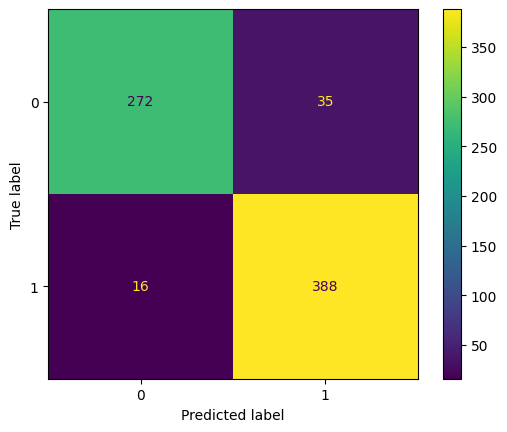

In [ ]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
display.plot()

## LightGBM

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.2, 0.3]),
        'num_leaves': trial.suggest_categorical('num_leaves', [50, 100, 150, 200]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 12]),
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 150, 200]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 50, 100]),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0, step=0.1),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    model = lgb.LGBMClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', verbose=0).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-30 16:50:51,540] A new study created in memory with name: no-name-fa7f632f-3692-40d1-a270-5885291226a2


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 16:50:52,269] Trial 0 finished with value: 0.9085837520730712 and parameters: {'learning_rate': 0.3, 'num_leaves': 150, 'max_depth': 5, 'n_estimators': 100, 'min_child_samples': 100, 'subsample': 0.9, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9085837520730712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:50:53,057] Trial 1 finished with value: 0.9113969405183295 and parameters: {'learning_rate': 0.3, 'num_leaves': 50, 'max_depth': 3, 'n_estimators': 150, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 1 with value: 0.9113969405183295.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 16:50:54,171] Trial 2 finished with value: 0.9156167231862173 and parameters: {'learning_rate': 0.1, 'num_leaves': 200, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.9156167231862173.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-30 16:50:55,884] Trial 3 finished with value: 0.9173741924305057 and parameters: {'learning_rate': 0.05, 'num_leaves': 150, 'max_depth': 12, 'n_estimators': 150, 'min_child_samples': 50, 'subsample': 0.9, 'colsample_bytree': 1.0, 'class_weight': None}. Best is trial 3 with value: 0.9173741924305057.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:50:56,428] Trial 4 finished with value: 0.9117478155399887 and parameters: {'learning_rate': 0.3, 'num_leaves': 200, 'max_depth': 5, 'n_estimators': 50, 'min_child_samples': 50, 'subsample': 1.0, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.9173741924305057.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-30 16:50:57,449] Trial 5 finished with value: 0.9113944652095348 and parameters: {'learning_rate': 0.3, 'num_leaves': 50, 'max_depth': 3, 'n_estimators': 100, 'min_child_samples': 50, 'subsample': 1.0, 'colsample_bytree': 1.0, 'class_weight': None}. Best is trial 3 with value: 0.9173741924305057.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 2276, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608084 -> initscore=0.439267
[LightGBM] [Info] Start training from score 0.439267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-30 16:50:59,778] Trial 6 finished with value: 0.9117465778855912 and parameters: {'learning_rate': 0.3, 'num_leaves': 200, 'max_depth': 12, 'n_estimators': 100, 'min_child_samples': 50, 'subsample': 0.8, 'colsample_bytree': 1.0, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.9173741924305057.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 16:51:06,320] Trial 7 finished with value: 0.9124532785464986 and parameters: {'learning_rate': 0.05, 'num_leaves': 150, 'max_depth': 12, 'n_estimators': 150, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.9, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.9173741924305057.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

[I 2024-11-30 16:51:07,278] Trial 8 finished with value: 0.9121005470432436 and parameters: {'learning_rate': 0.05, 'num_leaves': 50, 'max_depth': 12, 'n_estimators': 50, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.9173741924305057.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 16:51:08,658] Trial 9 finished with value: 0.9120993093888462 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 5, 'n_estimators': 100, 'min_child_samples': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.9173741924305057.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:10,638] Trial 10 finished with value: 0.9082297829154188 and parameters: {'learning_rate': 0.2, 'num_leaves': 150, 'max_depth': 12, 'n_estimators': 150, 'min_child_samples': 50, 'subsample': 0.9, 'colsample_bytree': 1.0, 'class_weight': None}. Best is trial 3 with value: 0.9173741924305057.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:12,121] Trial 11 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 200, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-30 16:51:13,555] Trial 12 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:14,952] Trial 13 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608352 -> initscore=0.440389
[LightGBM] [Info] Start training fro

[I 2024-11-30 16:51:15,923] Trial 14 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:16,939] Trial 15 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-30 16:51:18,227] Trial 16 finished with value: 0.9156142478774228 and parameters: {'learning_rate': 0.2, 'num_leaves': 200, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-30 16:51:19,518] Trial 17 finished with value: 0.9191298051931979 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-30 16:51:20,828] Trial 18 finished with value: 0.9187801678259362 and parameters: {'learning_rate': 0.1, 'num_leaves': 200, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 1.0, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-30 16:51:21,782] Trial 19 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:22,175] Trial 20 finished with value: 0.9152633728557638 and parameters: {'learning_rate': 0.2, 'num_leaves': 200, 'max_depth': 5, 'n_estimators': 50, 'min_child_samples': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:23,141] Trial 21 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:24,121] Trial 22 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:25,103] Trial 23 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:26,066] Trial 24 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 2276, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608084 -> initscore=0.439267
[LightGBM] [Info] Start training from score 0.439267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-30 16:51:27,019] Trial 25 finished with value: 0.9187801678259362 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 1.0, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:27,992] Trial 26 finished with value: 0.9187801678259362 and parameters: {'learning_rate': 0.1, 'num_leaves': 200, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[I 2024-11-30 16:51:28,971] Trial 27 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 50, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:29,384] Trial 28 finished with value: 0.9131519344538231 and parameters: {'learning_rate': 0.05, 'num_leaves': 100, 'max_depth': 5, 'n_estimators': 50, 'min_child_samples': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608352 -> initscore=0.440389
[LightGBM] [Info] Start training from score 0.440389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-30 16:51:29,923] Trial 29 finished with value: 0.9187801678259362 and parameters: {'learning_rate': 0.2, 'num_leaves': 150, 'max_depth': 3, 'n_estimators': 100, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:31,159] Trial 30 finished with value: 0.9145610039852471 and parameters: {'learning_rate': 0.1, 'num_leaves': 200, 'max_depth': 5, 'n_estimators': 200, 'min_child_samples': 100, 'subsample': 1.0, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:32,400] Trial 31 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608352 -> initscore=0.440389
[LightGBM] [Info] Start training from score 0.440389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-30 16:51:33,705] Trial 32 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-30 16:51:34,981] Trial 33 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 11 with value: 0.9212412435951386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:35,824] Trial 34 finished with value: 0.9229999504938242 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 150, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 2276, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608084 -> initscore=0.439267
[LightGBM] [Info] Start training from score 0.439267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-30 16:51:36,588] Trial 35 finished with value: 0.9113969405183295 and parameters: {'learning_rate': 0.3, 'num_leaves': 50, 'max_depth': 3, 'n_estimators': 150, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:37,378] Trial 36 finished with value: 0.9159669793806777 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 150, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:38,149] Trial 37 finished with value: 0.9089340082675313 and parameters: {'learning_rate': 0.3, 'num_leaves': 200, 'max_depth': 3, 'n_estimators': 150, 'min_child_samples': 50, 'subsample': 0.9, 'colsample_bytree': 1.0, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 2276, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608084 -> initscore=0.439267
[LightGBM] [Info] Start training from score 0.439267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-30 16:51:40,442] Trial 38 finished with value: 0.9124532785464986 and parameters: {'learning_rate': 0.05, 'num_leaves': 150, 'max_depth': 12, 'n_estimators': 150, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.9, 'class_weight': 'balanced'}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:41,252] Trial 39 finished with value: 0.9191322805019926 and parameters: {'learning_rate': 0.1, 'num_leaves': 200, 'max_depth': 3, 'n_estimators': 150, 'min_child_samples': 50, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:41,944] Trial 40 finished with value: 0.9078776702393624 and parameters: {'learning_rate': 0.3, 'num_leaves': 50, 'max_depth': 5, 'n_estimators': 100, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 1.0, 'class_weight': 'balanced'}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608352 -> initscore=0.440389
[LightGBM] [Info] Start training from score 0.440389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-30 16:51:42,972] Trial 41 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:43,355] Trial 42 finished with value: 0.9170220797544495 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 50, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Info] Start training from score 0.440389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2024-11-30 16:51:44,360] Trial 43 finished with value: 0.9212412435951386 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:46,546] Trial 44 finished with value: 0.9138567786331345 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 12, 'n_estimators': 150, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608352 -> initscore=0.440389
[LightGBM] [Info] Start training from score 0.440389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-30 16:51:47,812] Trial 45 finished with value: 0.9198346493725091 and parameters: {'learning_rate': 0.05, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 200, 'min_child_samples': 50, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-30 16:51:48,754] Trial 46 finished with value: 0.9201867620485655 and parameters: {'learning_rate': 0.1, 'num_leaves': 150, 'max_depth': 3, 'n_estimators': 100, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.8, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 2275, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 16:51:51,293] Trial 47 finished with value: 0.9138567786331345 and parameters: {'learning_rate': 0.2, 'num_leaves': 100, 'max_depth': 12, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.9, 'class_weight': 'balanced'}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:52,116] Trial 48 finished with value: 0.9177225921433699 and parameters: {'learning_rate': 0.1, 'num_leaves': 200, 'max_depth': 3, 'n_estimators': 150, 'min_child_samples': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-30 16:51:52,510] Trial 49 finished with value: 0.9170220797544495 and parameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 50, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.9, 'class_weight': None}. Best is trial 34 with value: 0.9229999504938242.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1384, number of negative: 892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 2276, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608084 -> initscore=0.439267
[LightGBM] [Info] Start training from score 0.439267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
best_params = study.best_params
best_model = lgb.LGBMClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

Best hyperparameters: {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 3, 'n_estimators': 150, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'class_weight': None}
Best cross-validation accuracy: 0.9229999504938242
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1730, number of negative: 1114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 2844, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608298 -> initscore=0.440164
[LightGBM] [Info] Start training from score 0.440164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

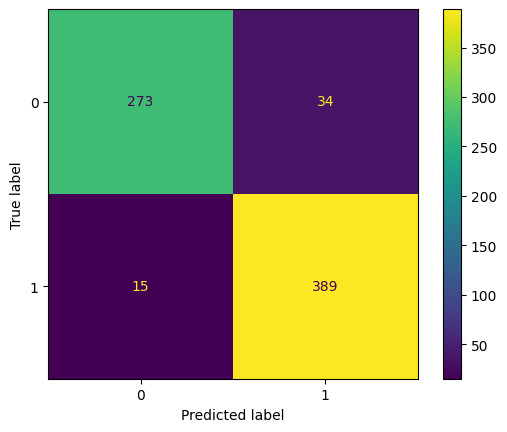

In [ ]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
display.plot()